## Importing the relevant libraries

In [124]:
import quandl, json, requests
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import r2_score
import pmdarima as pm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Fetching the total number of datasets available in the NASDAQ API through API calls

In [2]:
response = requests.get('https://www.quandl.com/api/v3/datasets/')
res = response.text
data = json.loads(res)
print(data)

{'datasets': [{'id': 9487650, 'dataset_code': 'BOM504991', 'database_code': 'BSE', 'name': 'VIDARBHA IRON & STEEL CORPORATION LTD. EOD Prices', 'description': 'End of Day prices and additional trading information for VIDARBHA IRON & STEEL CORPORATION LTD. EOD Prices.', 'refreshed_at': '2023-04-18T14:24:54.200Z', 'newest_available_date': '2099-12-27', 'oldest_available_date': '1991-01-03', 'column_names': ['Date', 'Open', 'High', 'Low', 'Close', 'WAP', 'No. of Shares', 'No. of Trades', 'Total Turnover', 'Deliverable Quantity', '% Deli. Qty to Traded Qty', 'Spread H-L', 'Spread C-O'], 'frequency': 'weekly', 'type': 'Time Series', 'premium': False, 'database_id': 3287}, {'id': 11273261, 'dataset_code': 'BOM511128', 'database_code': 'BSE', 'name': 'GALAXY CONSOLIDATED FINANCE LTD. EOD Prices', 'description': 'End of Day prices and additional trading information for GALAXY CONSOLIDATED FINANCE LTD. EOD Prices.', 'refreshed_at': '2023-04-18T14:25:01.921Z', 'newest_available_date': '2099-12-2

In [3]:
len(data)

2

In [4]:
data.keys()

dict_keys(['datasets', 'meta'])

In [5]:
len(data['datasets'])

100

In [6]:
# Creating a dataframe out of all columns obtained in the data dictionary
datasets = data['datasets']

dataset_codes = []
database_codes = []
names = []
descriptions = []
oldest_available_dates = []
newest_available_dates = []
col_names = []
frequencies = []

for x in datasets:
    dataset_codes.append(x['dataset_code'])
    database_codes.append(x['database_code'])
    names.append(x['name'])
    descriptions.append(x['description'])
    oldest_available_dates.append(x['oldest_available_date'])
    newest_available_dates.append(x['newest_available_date'])
    col_names.append(x['column_names'])
    frequencies.append(x['frequency'])

In [7]:
available_datasets = pd.DataFrame({'dataset_code': dataset_codes, 'database_code': database_codes, 'name': names, 'description': descriptions, 'oldest_available_date': oldest_available_dates, 'newest_available_date': newest_available_dates, 'columns': col_names, 'frequency': frequencies})
available_datasets.head()

,dataset_code,database_code,name,description,oldest_available_date,newest_available_date,columns,frequency
0,BOM504991,BSE,VIDARBHA IRON & STEEL CORPORATION LTD. EOD Prices,End of Day prices and additional trading infor...,1991-01-03,2099-12-27,"[Date, Open, High, Low, Close, WAP, No. of Sha...",weekly
1,BOM511128,BSE,GALAXY CONSOLIDATED FINANCE LTD. EOD Prices,End of Day prices and additional trading infor...,1995-09-14,2099-12-24,"[Date, Open, High, Low, Close, WAP, No. of Sha...",daily
2,BOM512415,BSE,MERCURY TRADE LINKS LTD. EOD Prices,End of Day prices and additional trading infor...,1992-01-22,2099-12-16,"[Date, Open, High, Low, Close, WAP, No. of Sha...",daily
3,BOM531743,BSE,HIRA AUTOMOBILES LTD. EOD Prices,End of Day prices and additional trading infor...,1996-07-17,2099-11-30,"[Date, Open, High, Low, Close, WAP, No. of Sha...",daily
4,BOM531724,BSE,HRB FLORICULTURE LTD. EOD Prices,End of Day prices and additional trading infor...,1996-06-11,2099-11-26,"[Date, Open, High, Low, Close, WAP, No. of Sha...",daily


## Extracting the stock data of Quick Heal Technologies Pvt. Ltd.

In [8]:
quick_heal_stock_data = quandl.get('BSE/BOM539678',authtoken="z8mJEsRrqvq8UiezE7hk")
quick_heal_stock_data.head()

,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O
Date,,,,,,,,,,,,
2017-02-21,254.25,259.5,253.0,257.75,257.17,40544.0,1048.0,10426526.0,9129.0,22.52,6.5,3.50
2017-02-22,257.00,261.0,252.6,253.05,256.18,35603.0,1067.0,9120718.0,8450.0,23.73,8.4,-3.95
2017-02-23,253.30,254.6,249.2,250.55,251.99,26262.0,600.0,6617792.0,13570.0,51.67,5.4,-2.75
2017-02-27,251.40,252.0,244.0,247.50,249.58,28019.0,732.0,6992855.0,11992.0,42.80,8.0,-3.90
2017-02-28,248.50,253.5,247.6,248.50,249.88,66735.0,1514.0,16675820.0,13474.0,20.19,5.9,0.00


In [9]:
quick_heal_stock_data.shape

(1523, 12)

## Fetching the stock data of Capital Trust Ltd.

In [10]:
capital_trust_stocks = quandl.get('BSE/BOM511505',authtoken="z8mJEsRrqvq8UiezE7hk")
capital_trust_stocks.head()

,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O
Date,,,,,,,,,,,,
1994-07-25,13.0,13.00,13.0,13.0,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.0
1994-07-26,13.0,15.00,13.0,13.0,0.0,0.0,0.0,0.0,NaN,NaN,2.00,0.0
1994-07-27,13.5,14.00,13.5,14.0,0.0,0.0,0.0,0.0,NaN,NaN,0.50,0.5
1994-07-28,14.0,18.75,14.0,17.5,0.0,0.0,0.0,0.0,NaN,NaN,4.75,3.5
1994-07-29,18.0,18.00,18.0,18.0,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.0


In [11]:
capital_trust_stocks.shape

(4660, 12)

## Extracting stock data of the HDFC Bank

In [12]:
hdfc_stock_data = quandl.get("BSE/BOM500180",authtoken="z8mJEsRrqvq8UiezE7hk")
hdfc_stock_data.head()

,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O
Date,,,,,,,,,,,,
1995-05-26,42.00,45.00,38.50,40.00,0.000000,0.0,0.0,0.0,NaN,NaN,6.50,-2.00
1995-05-29,39.00,40.25,38.75,39.25,0.000000,0.0,0.0,0.0,NaN,NaN,1.50,0.25
1995-05-30,39.00,40.00,39.00,39.50,0.000000,0.0,0.0,0.0,NaN,NaN,1.00,0.50
1995-05-31,39.75,40.25,39.50,40.25,0.000000,0.0,0.0,0.0,NaN,NaN,0.75,0.50
1996-04-02,33.00,35.00,33.00,34.75,33.878745,70100.0,208.0,2374900.0,NaN,NaN,2.00,1.75


In [13]:
hdfc_stock_data.shape

(6713, 12)

## Fetching stock data of Infosys Technologies Pvt. Ltd.

In [14]:
infosys_stock_data = quandl.get("BSE/BOM500209",authtoken="z8mJEsRrqvq8UiezE7hk")
infosys_stock_data.head()

,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O
Date,,,,,,,,,,,,
1995-05-02,450.0,450.0,450.0,450.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0
1995-05-03,440.0,440.0,420.0,440.0,0.0,0.0,0.0,0.0,NaN,NaN,20.0,0.0
1995-05-04,450.0,460.0,450.0,460.0,0.0,0.0,0.0,0.0,NaN,NaN,10.0,10.0
1995-05-05,480.0,480.0,470.0,480.0,0.0,0.0,0.0,0.0,NaN,NaN,10.0,0.0
1995-05-08,480.0,480.0,475.0,480.0,0.0,0.0,0.0,0.0,NaN,NaN,5.0,0.0


In [15]:
infosys_stock_data.shape

(6728, 12)

## Saving these 4 stocks into CSV files 

In [16]:
quick_heal_stock_data.to_csv('quick_heal_technologies_stocks.csv')

In [17]:
capital_trust_stocks.to_csv('capital_trust_stocks.csv')

In [18]:
hdfc_stock_data.to_csv('hdfc_stocks.csv')

In [19]:
infosys_stock_data.to_csv('infosys_stocks.csv')

## Data Visualization

<AxesSubplot: xlabel='Date'>

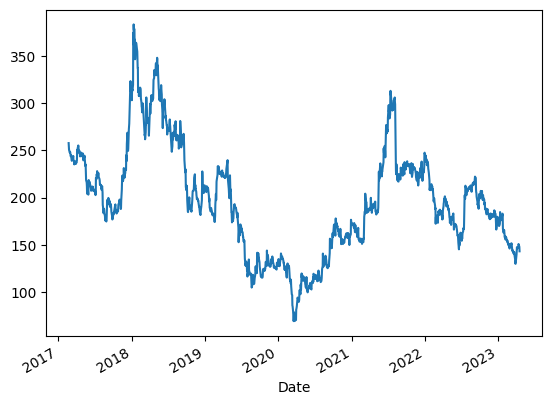

In [20]:
quick_heal_stock_data.Close.plot()

<AxesSubplot: xlabel='Date'>

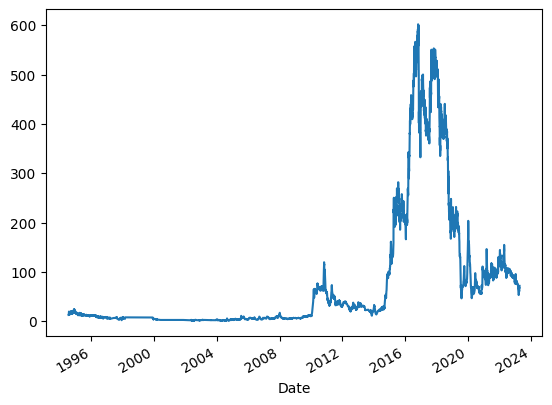

In [21]:
capital_trust_stocks.Close.plot()

<AxesSubplot: xlabel='Date'>

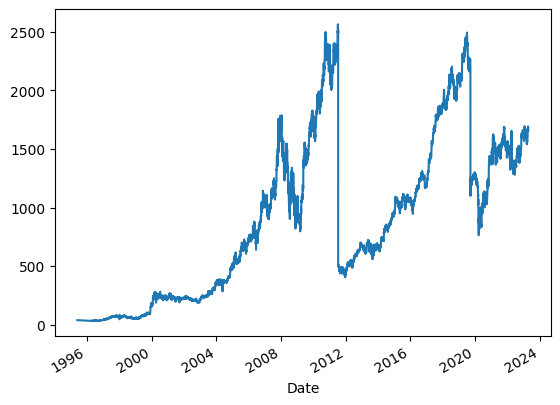

In [22]:
hdfc_stock_data.Close.plot()

<AxesSubplot: xlabel='Date'>

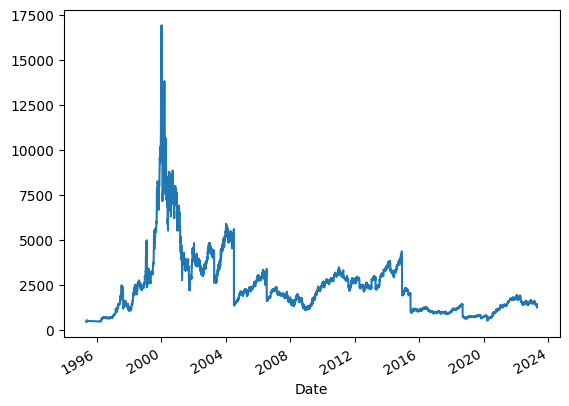

In [23]:
infosys_stock_data.Close.plot()

In [24]:
# Custom function to implement the Augmented Dickey Fuller Test for checking the stationarity of stock data
def ad_fuller_test(col):
    result = adfuller(col)
    print("Test Statistic:",result[0])
    print("p-value:",result[1])
    
    if result[1] < 0.05:
        print("Stationary")
    else:
        print("Not Stationary")

In [25]:
ad_fuller_test(capital_trust_stocks.Close)

Test Statistic: -1.5120619254231884
p-value: 0.5275362624683955
Not Stationary


In [26]:
ad_fuller_test(infosys_stock_data.Close)

Test Statistic: -2.5400767700289233
p-value: 0.10602515373854388
Not Stationary


In [27]:
ad_fuller_test(quick_heal_stock_data.Close)

Test Statistic: -2.1456399332556026
p-value: 0.22656274251666775
Not Stationary


In [28]:
ad_fuller_test(hdfc_stock_data.Close)

Test Statistic: -2.1019511159385753
p-value: 0.24373077211060257
Not Stationary


The stock data of all 4 companies is non stationary so it needs to be made stationary by applying some data transformation operations.

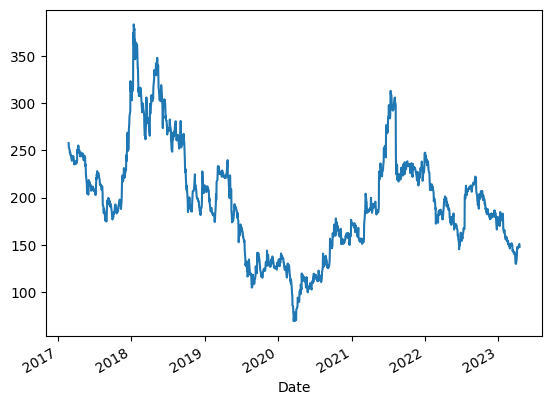

In [29]:
quick_heal_stocks = quick_heal_stock_data.Close.shift(1) # Applying the shift operation by 1 step
quick_heal_stocks.plot();

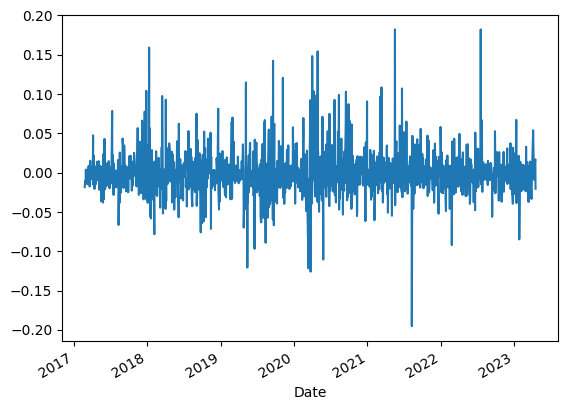

In [30]:
# Determining Log Percentage Change of Quick Heal stocks
quick_heal_stocks = np.log1p(quick_heal_stocks.pct_change(1))
quick_heal_stocks.plot();

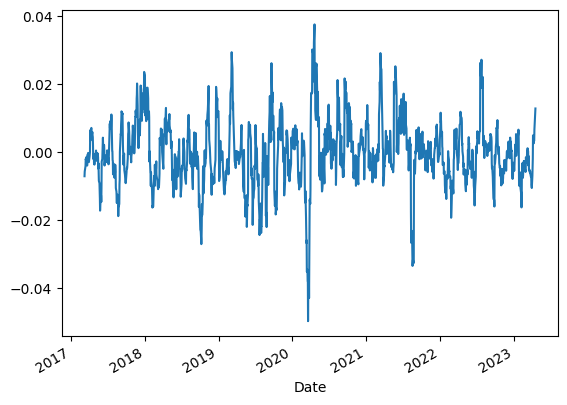

In [31]:
# Computing Simple Moving Average with a rolling window of 10 
quick_heal_sma_10 = quick_heal_stocks.rolling(window=10).mean()
quick_heal_sma_10.plot();

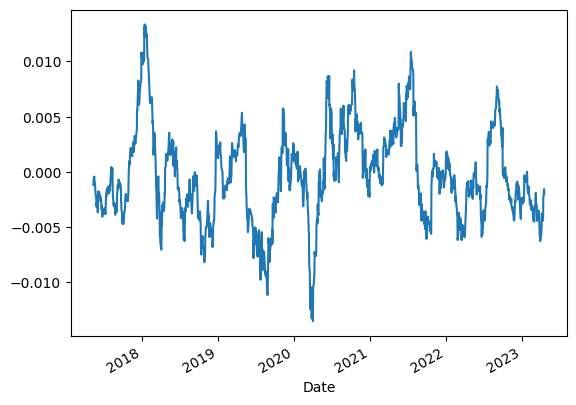

In [32]:
# Computing Simple Moving Average with a rolling window of 50
quick_heal_sma_50 = quick_heal_stocks.rolling(window=50).mean()
quick_heal_sma_50.plot();

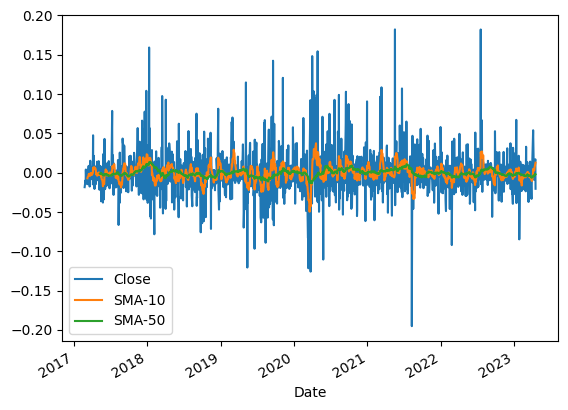

In [33]:
# Visualizing original close prices and SMA together
quick_heal_df = pd.concat([quick_heal_stocks,quick_heal_sma_10,quick_heal_sma_50],axis=1)
quick_heal_df.columns = ['Close','SMA-10','SMA-50']
quick_heal_df.plot();

In [34]:
# Computing Exponentially Weighted Moving Average (EWMA) with an alpha value of 0.2
quick_heal_stock_data['EWMA_Close'] = quick_heal_stock_data.Close.ewm(alpha=0.2,adjust=False).mean()
quick_heal_stock_data.head()

,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O,EWMA_Close
Date,,,,,,,,,,,,,
2017-02-21,254.25,259.5,253.0,257.75,257.17,40544.0,1048.0,10426526.0,9129.0,22.52,6.5,3.50,257.75000
2017-02-22,257.00,261.0,252.6,253.05,256.18,35603.0,1067.0,9120718.0,8450.0,23.73,8.4,-3.95,256.81000
2017-02-23,253.30,254.6,249.2,250.55,251.99,26262.0,600.0,6617792.0,13570.0,51.67,5.4,-2.75,255.55800
2017-02-27,251.40,252.0,244.0,247.50,249.58,28019.0,732.0,6992855.0,11992.0,42.80,8.0,-3.90,253.94640
2017-02-28,248.50,253.5,247.6,248.50,249.88,66735.0,1514.0,16675820.0,13474.0,20.19,5.9,0.00,252.85712


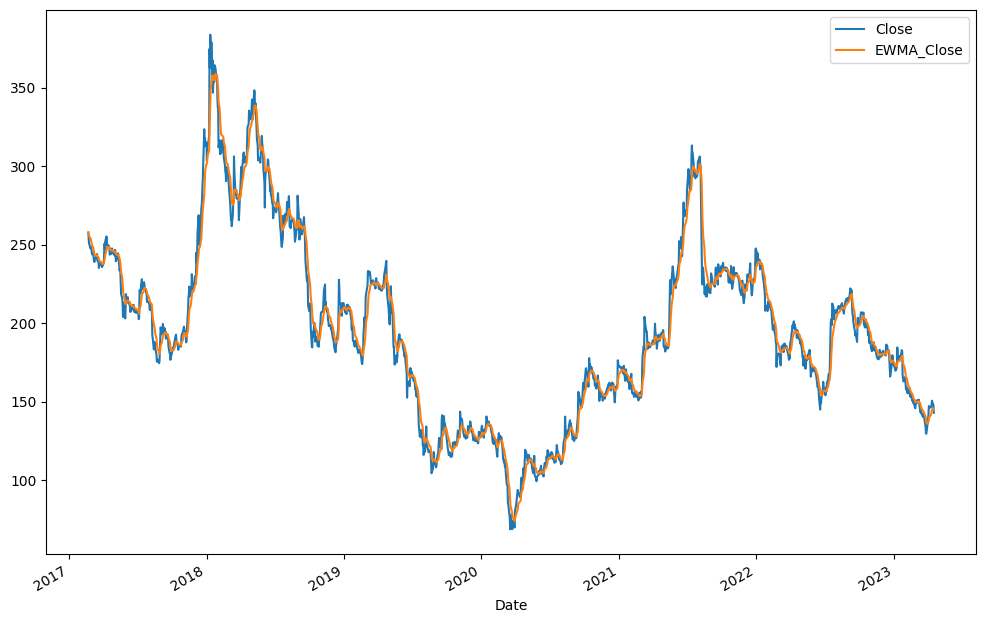

In [35]:
quick_heal_stock_data[['Close','EWMA_Close']].plot(figsize=(12,8));

## Applying log and differencing transforms to stocks data of all 4 companies

### Infosys

<AxesSubplot: xlabel='Date'>

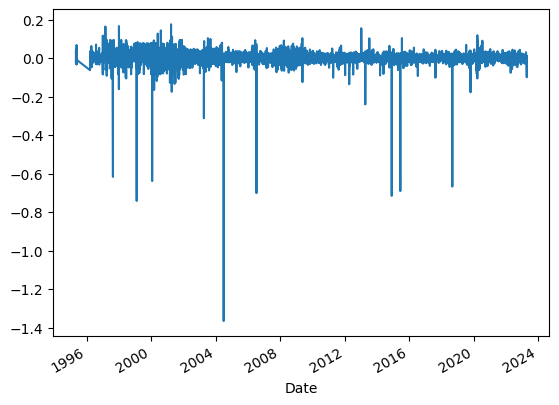

In [36]:
infosys_stock_data['LogClose'] = np.log(infosys_stock_data.Close) # Applying log transform
infosys_stock_data['Log_Close_Diff'] = infosys_stock_data.LogClose.diff() # Applying differencing on the log transformed data
infosys_stock_data.Log_Close_Diff.plot()

In [38]:
ad_fuller_test(infosys_stock_data.Log_Close_Diff.dropna())

Test Statistic: -81.43841191454013
p-value: 0.0
Stationary


### Capital Trust

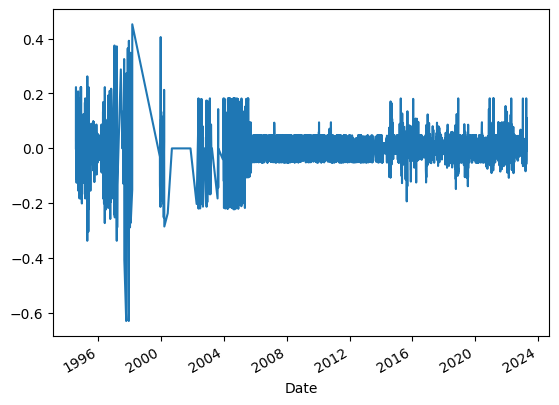

In [39]:
capital_trust_stocks['LogClose'] = np.log(capital_trust_stocks.Close)
capital_trust_stocks['Diff_Log_Close'] = capital_trust_stocks.LogClose.diff()
capital_trust_stocks.Diff_Log_Close.plot();

In [40]:
ad_fuller_test(capital_trust_stocks.Diff_Log_Close.dropna())

Test Statistic: -12.764454128645871
p-value: 8.013246978024532e-24
Stationary


### HDFC Bank

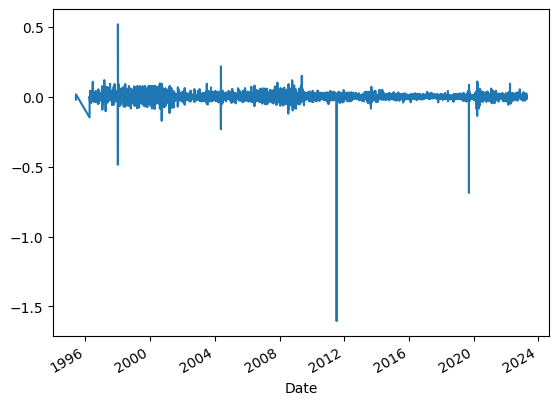

In [41]:
hdfc_stock_data['LogClose'] = np.log(hdfc_stock_data.Close)
hdfc_stock_data['Diff_Log_Close'] = hdfc_stock_data.LogClose.diff()
hdfc_stock_data.Diff_Log_Close.plot();

In [42]:
ad_fuller_test(hdfc_stock_data.Diff_Log_Close.dropna())

Test Statistic: -60.629566476023506
p-value: 0.0
Stationary


### Quick Heal

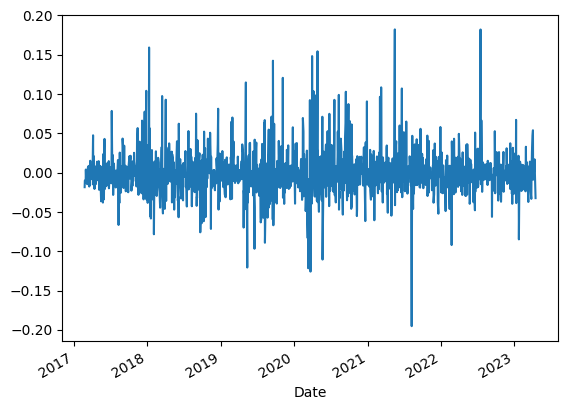

In [43]:
quick_heal_stock_data['LogClose'] = np.log(quick_heal_stock_data.Close)
quick_heal_stock_data['Diff_Log_Close'] = quick_heal_stock_data.LogClose.diff()
quick_heal_stock_data.Diff_Log_Close.plot();

In [44]:
ad_fuller_test(quick_heal_stock_data.Diff_Log_Close.dropna())

Test Statistic: -38.49582326326499
p-value: 0.0
Stationary


## Predictive Analysis and Forecasting

### Simple Exponential Smoothing Model

In [45]:
ses = SimpleExpSmoothing(quick_heal_stock_data.Close)
ses

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [46]:
res = ses.fit(smoothing_level=0.2,optimized=False)

In [47]:
quick_heal_stock_data['SES'] = res.predict(start=quick_heal_stock_data.index[0],end=quick_heal_stock_data.index[-1])

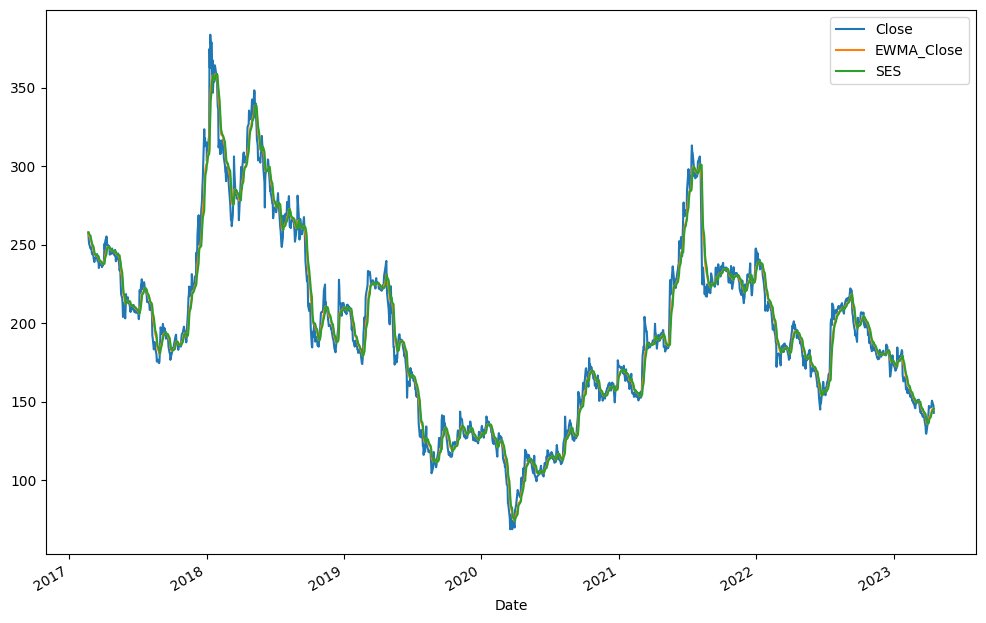

In [48]:
quick_heal_stock_data[['Close','EWMA_Close','SES']].plot(figsize=(12,8));

In [49]:
# Splitting the stock data into train and test sets
N_Test = 10 # No. of forecasting steps
train = quick_heal_stock_data.iloc[:-N_Test]
test = quick_heal_stock_data.iloc[-N_Test:]

In [50]:
# Training the Simple Exponential Smoothing model
ses = SimpleExpSmoothing(train.Close)
res = ses.fit()

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [51]:
train_idx = quick_heal_stock_data.index <= train.index[-1]
test_idx = quick_heal_stock_data.index > train.index[-1]

In [52]:
quick_heal_stock_data.loc[train_idx,'SES_Fitted'] = res.fittedvalues
quick_heal_stock_data.loc[test_idx,'SES_Fitted'] = res.forecast(N_Test)

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


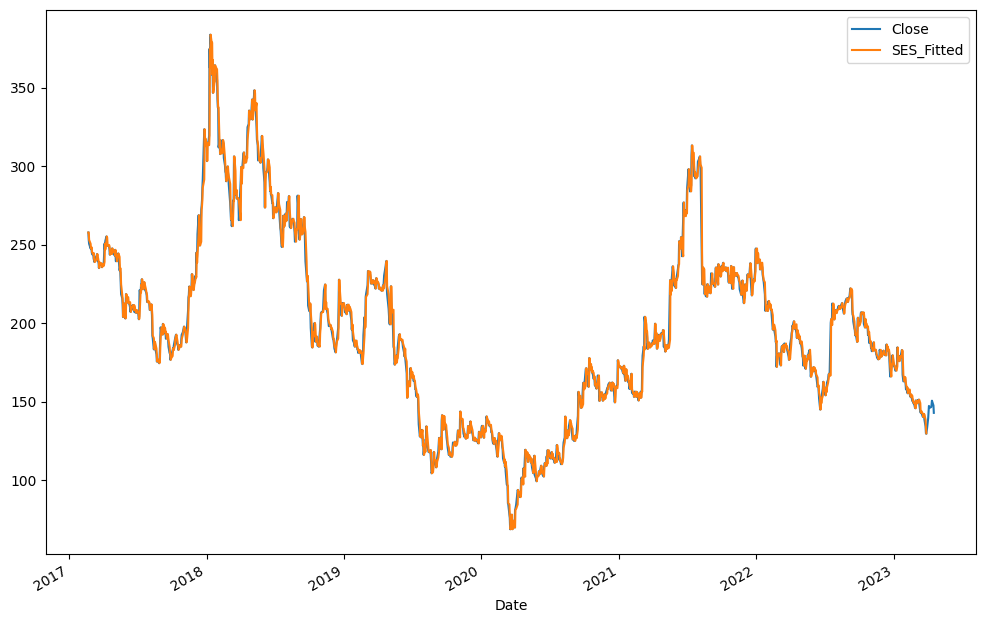

In [53]:
quick_heal_stock_data[['Close','SES_Fitted']].plot(figsize=(12,8));

In [54]:
res.params

{'smoothing_level': 0.9999999850988387,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 257.7498354254828,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

### Holt Model

In [55]:
holt = Holt(quick_heal_stock_data.Close)
res = holt.fit()

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


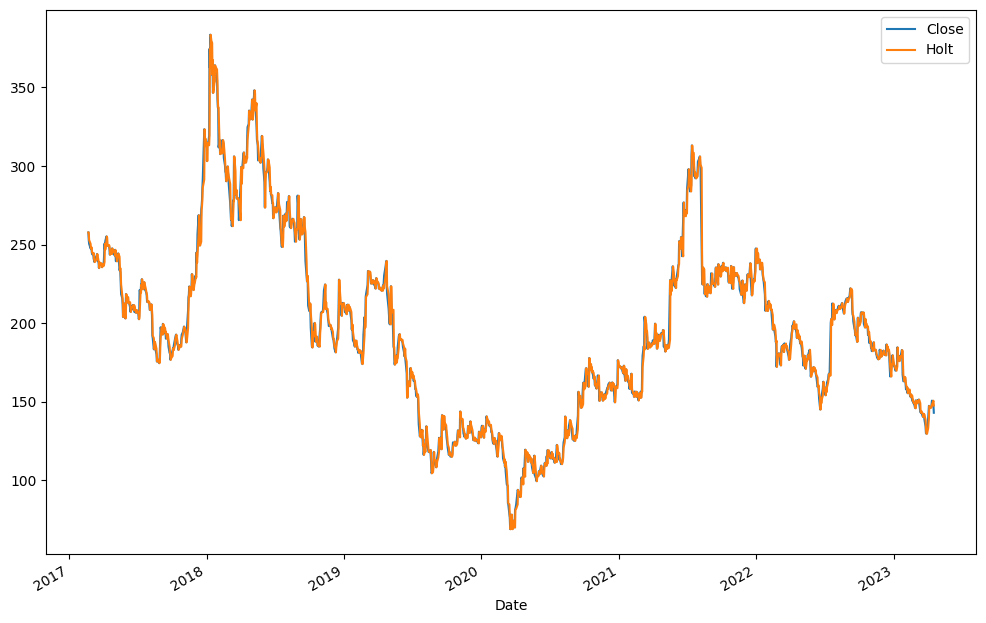

In [56]:
quick_heal_stock_data['Holt'] = res.fittedvalues
quick_heal_stock_data[['Close','Holt']].plot(figsize=(12,8));

In [57]:
holt = Holt(quick_heal_stock_data.Close)
res_holt = holt.fit()

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [58]:
quick_heal_stock_data.loc[train_idx,'Holt_Fitted'] = res_holt.fittedvalues
quick_heal_stock_data.loc[test_idx,'Holt_Fitted'] = res_holt.forecast(N_Test)

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


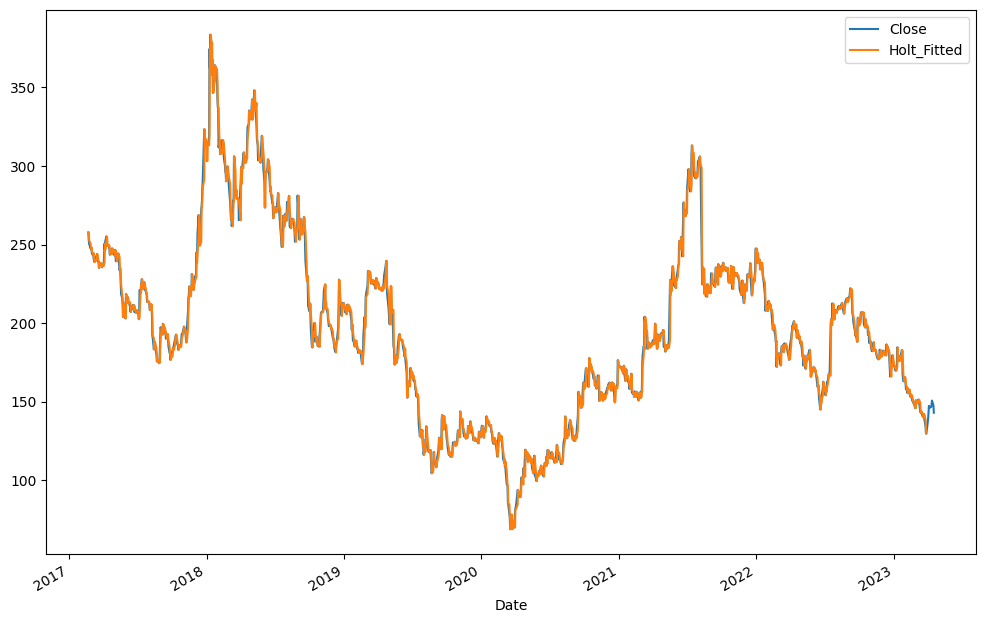

In [59]:
quick_heal_stock_data[['Close','Holt_Fitted']].plot(figsize=(12,8));

In [60]:
res_holt.params

{'smoothing_level': 0.9999996487532108,
 'smoothing_trend': 0.0,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 257.8253448808075,
 'initial_trend': -0.07523478050319204,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

### Holt-Winters Exponential Smoothing Model

<AxesSubplot: xlabel='Date'>

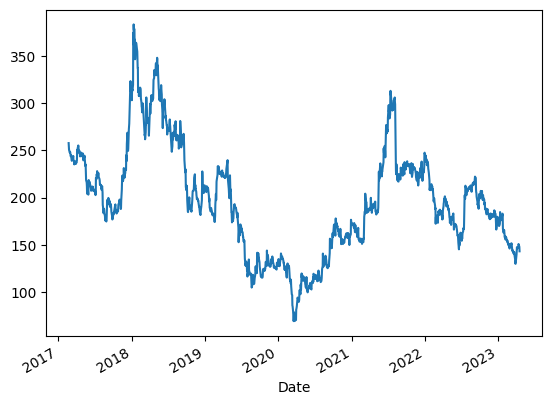

In [61]:
quick_heal_stock_data.Close.plot()

In [62]:
holt_winters = ExponentialSmoothing(quick_heal_stock_data.Close,use_boxcox=True)
res = holt_winters.fit()

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


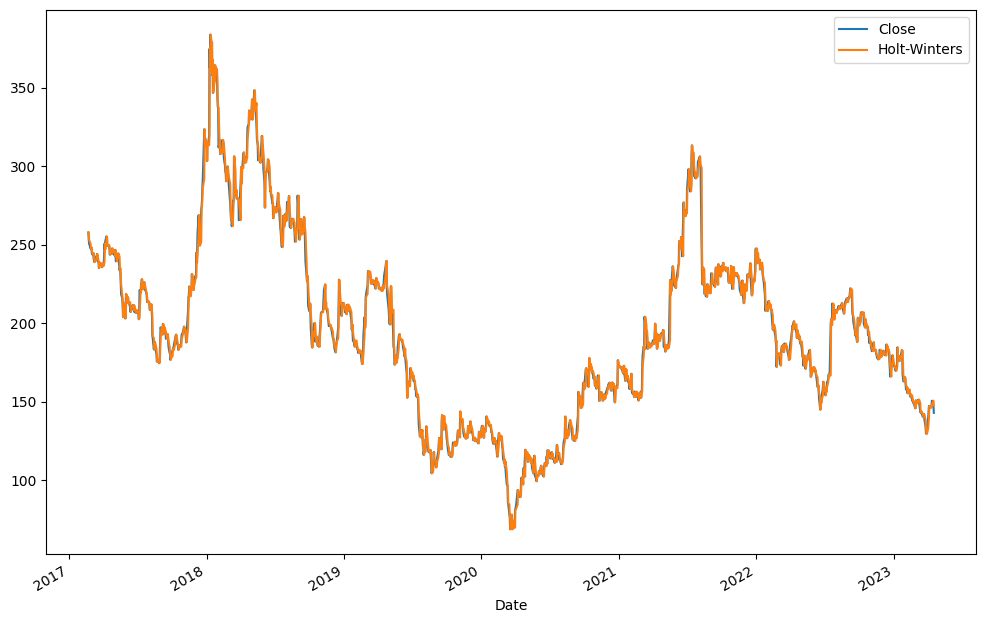

In [63]:
quick_heal_stock_data['Holt-Winters'] = res.fittedvalues
quick_heal_stock_data[['Close','Holt-Winters']].plot(figsize=(12,8));

In [64]:
quick_heal_stock_data.drop(['Holt-Winters','Holt','SES'],axis=1,inplace=True)

In [65]:
holt_winters = ExponentialSmoothing(quick_heal_stock_data.Close,use_boxcox=True)
res_holt_winters = holt_winters.fit()

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [66]:
quick_heal_stock_data.loc[train_idx,'Holt-Winters_Fitted'] = res_holt_winters.fittedvalues
quick_heal_stock_data.loc[test_idx,'Holt-Winters_Fitted'] = res_holt_winters.forecast(N_Test)

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


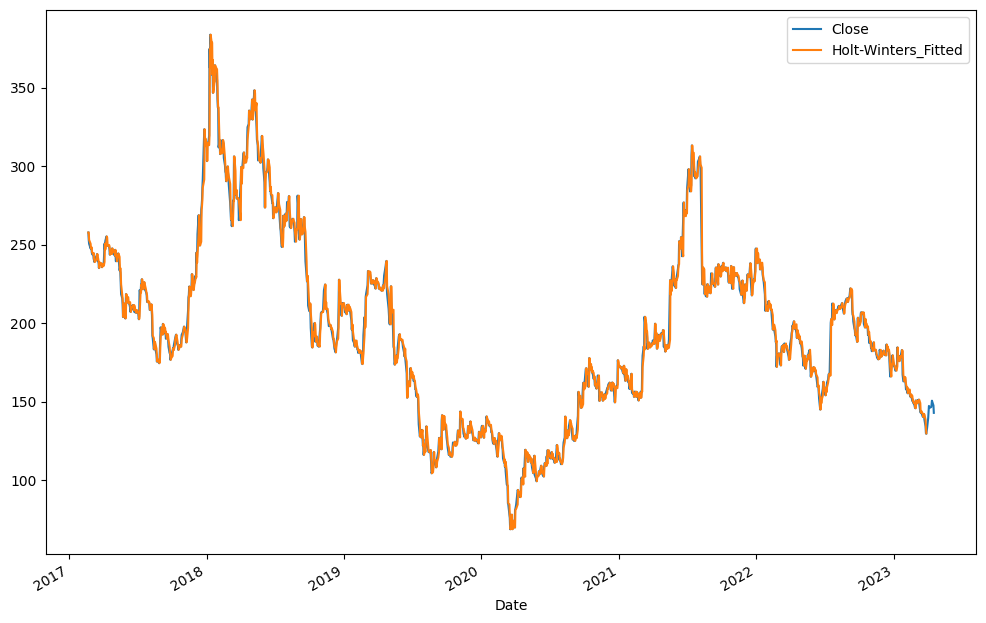

In [67]:
quick_heal_stock_data[['Close','Holt-Winters_Fitted']].plot(figsize=(12,8));

In [68]:
res_holt_winters.params

{'smoothing_level': 0.9999999850988386,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 21.233437800053085,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': True,
 'lamda': 0.40892862980264927,
 'remove_bias': False}

## Model Evaluation

In [69]:
# Custom function for calculating Mean Absolute Error (MAE)
def mean_absolute_error(y_test,pred):
    return np.mean(np.abs(y_test-pred))

In [70]:
# Custom function for calculating Root Mean Squared Error (RMSE)
def rmse(y_test,pred):
    return np.sqrt(np.mean((y_test-pred)**2))

## Model Evaluation

### Simple Exponential Smoothing Model

In [71]:
print("Train RMSE:",rmse(train.Close,res.fittedvalues))
print("Test RMSE:",rmse(test.Close.values,res.forecast(N_Test)))
print("Test R2:",r2_score(test.Close.values,res.forecast(N_Test)))

Train RMSE: 5.675941942076075
Test RMSE: 5.21265284983934
Test R2: -0.15791378989663496


D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Holt Model

In [72]:
print("Train RMSE:",rmse(train.Close,res_holt.fittedvalues))
print("Test RMSE:",rmse(test.Close.values,res_holt.forecast(N_Test)))
print("Test R2:",r2_score(test.Close.values,res_holt.forecast(N_Test)))

Train RMSE: 5.675318406664786
Test RMSE: 5.499529325430642
Test R2: -0.2888716309689652


D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Holt-Winters Exponential Smoothing Model

In [73]:
print("Train RMSE:",rmse(train.Close,res_holt_winters.fittedvalues))
print("Test RMSE:",rmse(test.Close.values,res_holt_winters.forecast(N_Test)))
print("Test R2:",r2_score(test.Close.values,res_holt_winters.forecast(N_Test)))

Train RMSE: 5.675941942076075
Test RMSE: 5.21265284983934
Test R2: -0.15791378989663496


D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Auto ARIMA Model

In [74]:
arima_model = pm.auto_arima(train.Close,
                           trace=True,
                           suppress_warnings=True,
                           seasonal=True,
                           m=12)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=9544.337, Time=5.15 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=9545.913, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=9545.501, Time=0.32 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=9545.042, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=9544.249, Time=0.04 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=9543.757, Time=0.45 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=9541.688, Time=0.90 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=9543.652, Time=2.67 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=9544.059, Time=0.86 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=9543.311, Time=1.23 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=9543.321, Time=1.29 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=9544.732, Time=4.36 sec
 ARIMA(0,1,0)(2,0,0)[12]             : AIC=9540.022, Time=0.33 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=9542.068, Time=0.10 sec
 ARIMA(0,1,0)(2,0,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1513
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 12)   Log Likelihood               -4767.011
Date:                            Wed, 19 Apr 2023   AIC                           9540.022
Time:                                    02:42:00   BIC                           9555.986
Sample:                                         0   HQIC                          9545.967
                                           - 1513                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0552      0.023      2.369      0.018       0.010       0.101
ar.S.L24      -0.0514      0.020     -2.548      0.011      -0.091      -0.012
sigma2        32.0610      0.408     78.608      0.000      31.262      32.860
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):             15315.22
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               0.66   Skew:                             0.87
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [75]:
test_pred, conf_int = arima_model.predict(n_periods=N_Test,return_conf_int=True)

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


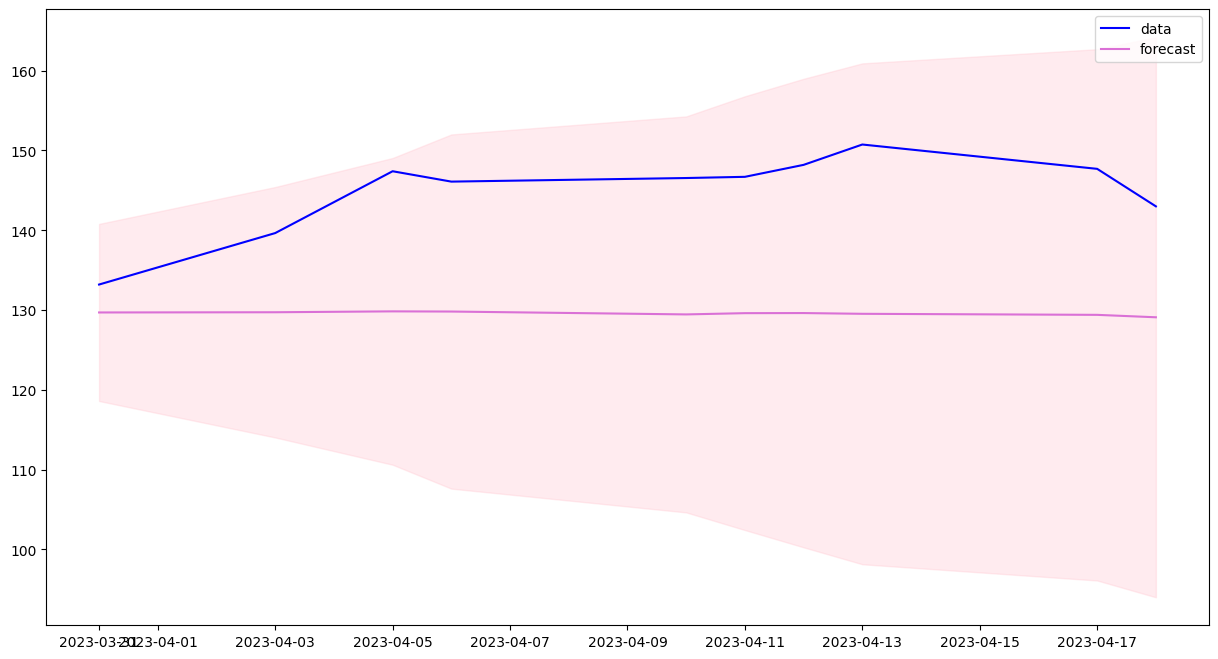

In [76]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(test.index,test.Close,color='blue',label='data')
ax.plot(test.index,test_pred,color='orchid',label='forecast')
ax.fill_between(test.index,conf_int[:,0],conf_int[:,1],color='pink',alpha=0.3)
ax.legend()

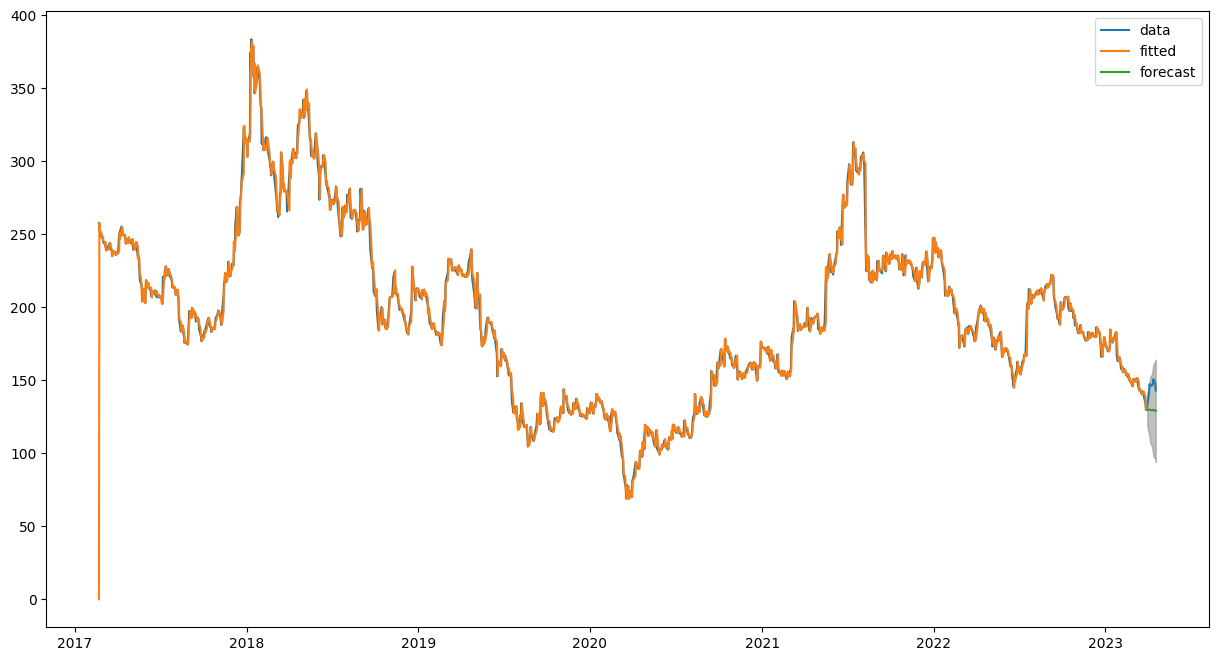

In [77]:
train_pred = arima_model.predict_in_sample()
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(quick_heal_stock_data.index,quick_heal_stock_data.Close,label='data')
ax.plot(train.index,train_pred,label='fitted')
ax.plot(test.index,test_pred,label='forecast')
ax.fill_between(test.index,conf_int[:,0],conf_int[:,1],color='grey',alpha=0.5)
ax.legend();

## Auto ARIMA Log Model

In [78]:
arima_log_model = pm.auto_arima(train.LogClose,
                               trace=True,
                               suppress_warnings=True)
arima_log_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6440.722, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6448.239, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6446.363, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6446.365, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6449.859, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6444.364, Time=0.31 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.869 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1513
Model:               SARIMAX(0, 1, 0)   Log Likelihood                3225.930
Date:                Wed, 19 Apr 2023   AIC                          -6449.859
Time:                        02:42:03   BIC                          -6444.538
Sample:                             0   HQIC                         -6447.878
                               - 1513                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0008   1.39e-05     59.178      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              3513.23
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.76
Prob(H) (two-sided):                  0.96   Kurtosis:                        10.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [79]:
test_pred, conf_int = arima_log_model.predict(n_periods=N_Test,return_conf_int=True)

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


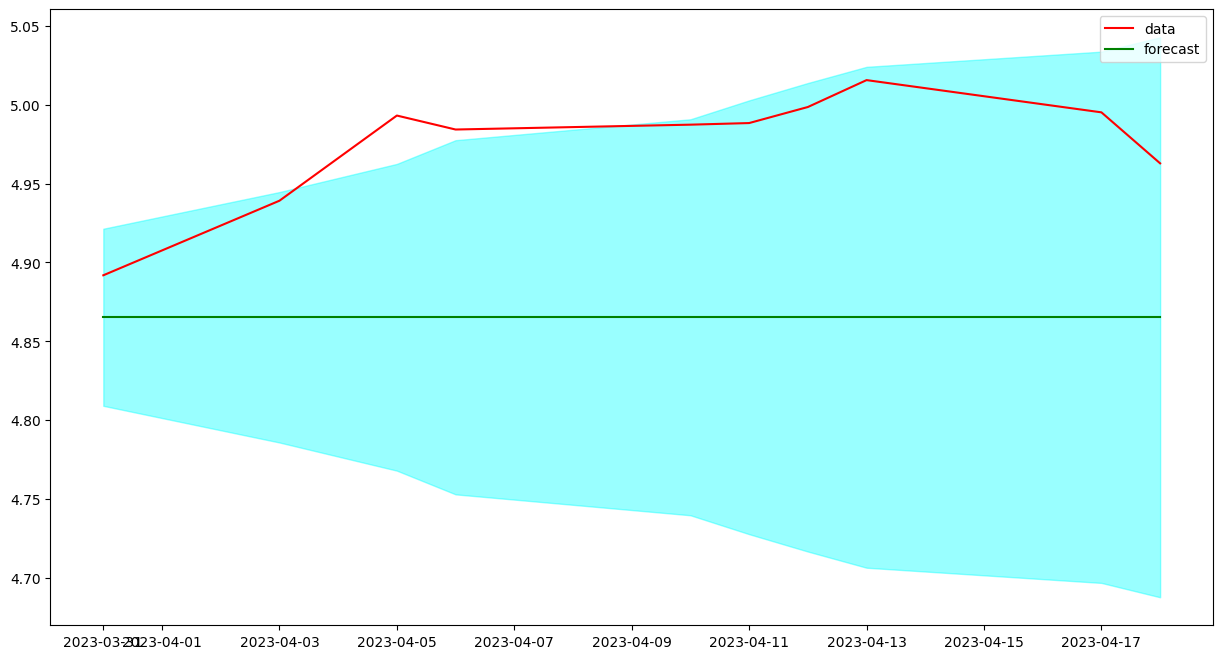

In [80]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(test.index,test.LogClose,color='red',label='data')
ax.plot(test.index,test_pred,color='green',label='forecast')
ax.fill_between(test.index,conf_int[:,0],conf_int[:,1],color='aqua',alpha=0.4)
ax.legend();

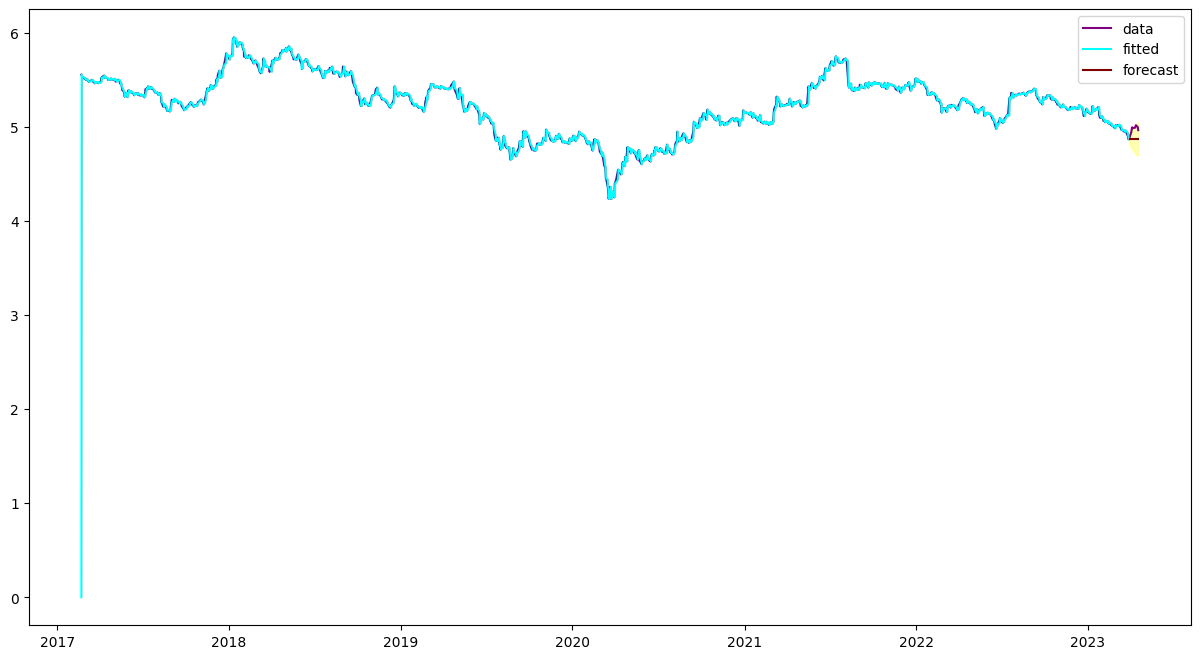

In [81]:
train_pred = arima_log_model.predict_in_sample()
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(quick_heal_stock_data.index,quick_heal_stock_data.LogClose,label='data',color='purple')
ax.plot(train.index,train_pred,label='fitted',color='cyan')
ax.plot(test.index,test_pred,label='forecast',color='maroon')
ax.fill_between(test.index,conf_int[:,0],conf_int[:,1],color='yellow',alpha=0.3)
ax.legend();

## Auto ARIMA Log Difference Model

In [82]:
arima_log_diff_model = pm.auto_arima(train.Diff_Log_Close.dropna(),
                                    trace=True,
                                    suppress_warnings=True,
                                    )
arima_log_diff_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-6440.722, Time=1.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-6448.239, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-6446.363, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-6446.365, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-6449.859, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-6444.364, Time=0.29 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 1.865 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1512
Model:                        SARIMAX   Log Likelihood                3225.930
Date:                Wed, 19 Apr 2023   AIC                          -6449.859
Time:                        02:42:05   BIC                          -6444.538
Sample:                             0   HQIC                         -6447.878
                               - 1512                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0008   1.39e-05     59.158      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              3513.23
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             0.76
Prob(H) (two-sided):                  0.96   Kurtosis:                        10.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [83]:
test_pred, conf_int = arima_log_diff_model.predict(n_periods=N_Test,return_conf_int=True)

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


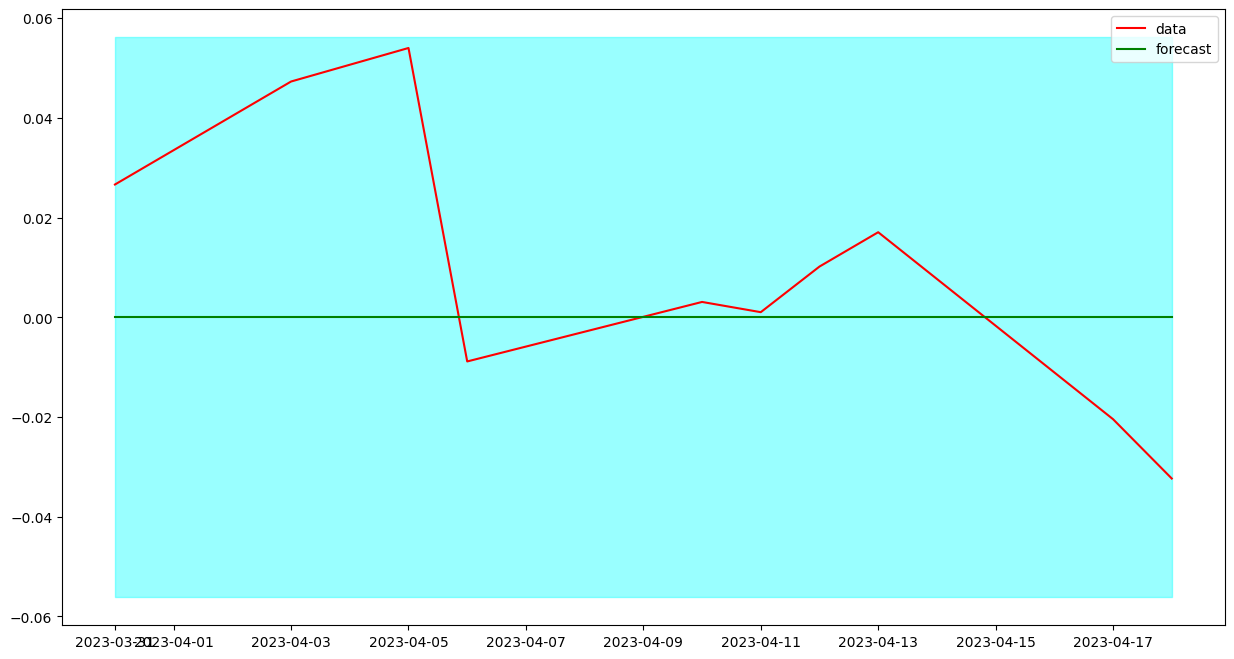

In [84]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(test.index,test.Diff_Log_Close.dropna(),color='red',label='data')
ax.plot(test.index,test_pred,color='green',label='forecast')
ax.fill_between(test.index,conf_int[:,0],conf_int[:,1],color='aqua',alpha=0.4)
ax.legend();

## Evaluating the Auto ARIMA models

In [85]:
print("Auto Arima Model:")
print("Train RMSE:",rmse(train.Close,arima_model.predict_in_sample()))
print("Test RMSE:",rmse(test.Close.values,arima_model.predict(n_periods=10,return_conf_int=False).values))
print("Test R2 Score:",r2_score(test.Close.values,arima_model.predict(n_periods=10,return_conf_int=False).values))
print("--------------------------")
print("Auto Arima Log Model:")
print("Train RMSE:",rmse(train.LogClose,arima_log_model.predict_in_sample()))
print("Test RMSE:",rmse(test.LogClose.values,arima_log_model.predict(n_periods=10,return_conf_int=False).values))
print("Test R2 Score:",r2_score(test.LogClose.values,arima_log_model.predict(n_periods=10,return_conf_int=False).values))
print("--------------------------")
print("Auto Arima Log Difference Model:")
print("Train RMSE:",rmse(train.Diff_Log_Close,arima_log_diff_model.predict_in_sample()))
print("Test RMSE:",rmse(test.Diff_Log_Close.values,arima_log_diff_model.predict(n_periods=10,return_conf_int=False).values))
print("Test R2 Score:",r2_score(test.Diff_Log_Close.values,arima_log_diff_model.predict(n_periods=10,return_conf_int=False).values))

Auto Arima Model:
Train RMSE: 8.714889155322835
Test RMSE: 16.09950039908311
Test R2 Score: -10.045450115861785
--------------------------
Auto Arima Log Model:
Train RMSE: 0.14558030712481196
Test RMSE: 0.11559463941272381
Test R2 Score: -10.416692619072462
--------------------------
Auto Arima Log Difference Model:
Train RMSE: 0.028653207720861322
Test RMSE: 0.027945264220363985
Test R2 Score: -0.13899084485224633


D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is

The Auto ARIMA Log Difference model performed comparatively better than Auto ARIMA Log Model and simple Auto ARIMA model, attaining a lower RMSE of less than approximately 0.028 on the test set.

## Training ARIMA model on HDFC bank stocks data

In [86]:
# Custom function for computing stock returns
def log_returns(price):
    log_price = np.log(price)
    return log_price.diff()

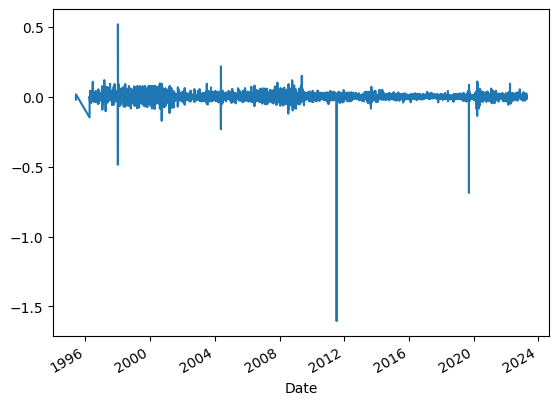

In [87]:
hdfc_stock_data['Log_Returns'] = log_returns(hdfc_stock_data.Close)
hdfc_stock_data.Log_Returns.plot();

In [88]:
ad_fuller_test(hdfc_stock_data.Log_Returns.dropna())

Test Statistic: -60.629566476023506
p-value: 0.0
Stationary


D:\Anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


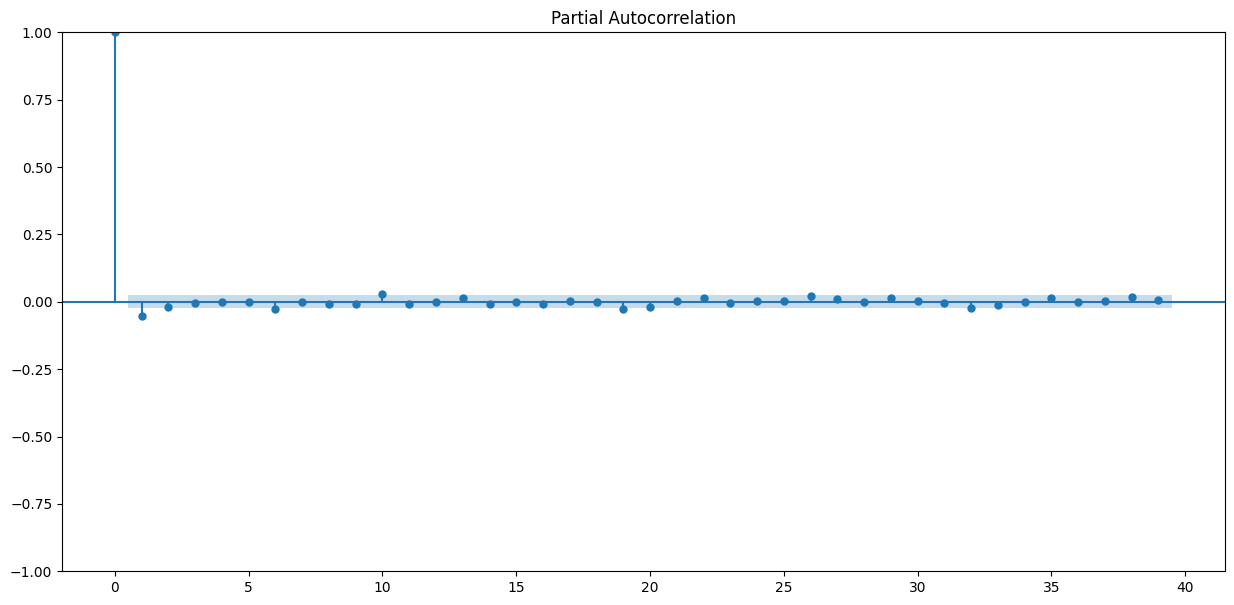

In [89]:
# Visualizing the Partial Autocorrelation Function for determining order of the Auto Regressive (AR) term i.e. the p value
fig, ax = plt.subplots(figsize=(15,7))
plot_pacf(hdfc_stock_data.Log_Returns.dropna(),ax=ax);

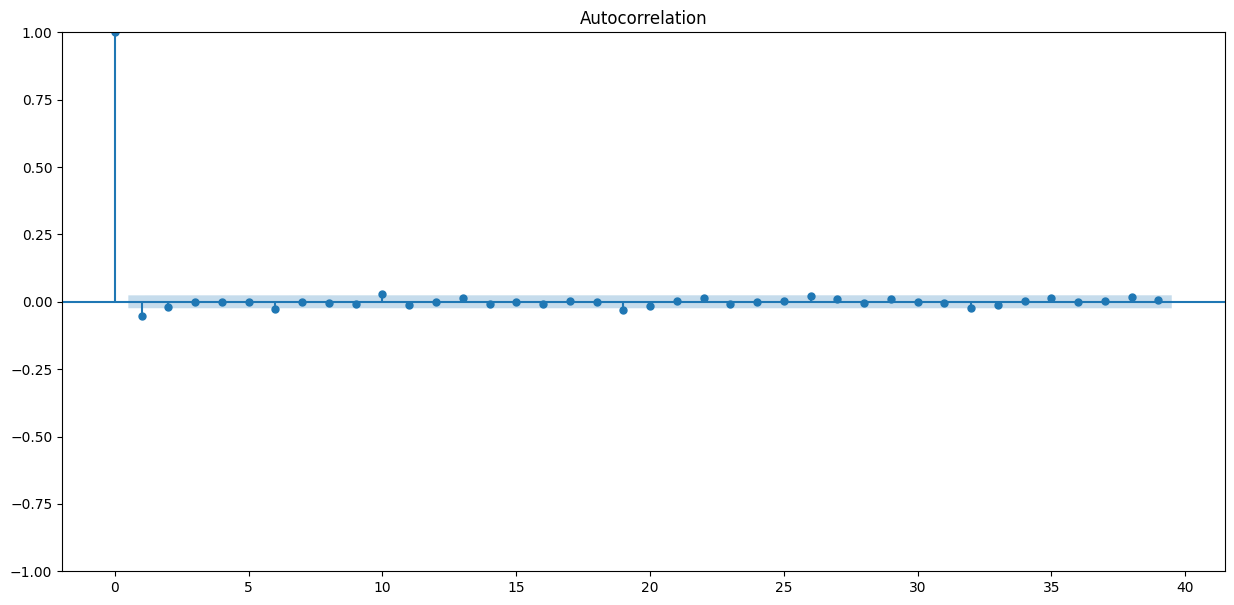

In [90]:
# Visualizing Autocorrelation Function (ACF) for finding order of the Moving Average (MA) term i.e. the q value
fig, ax = plt.subplots(figsize=(15,7))
plot_acf(hdfc_stock_data.Log_Returns.dropna(),ax=ax);

From the above ACF and PACF plots, we can clearly discern that the HDFC stock returns follow a (0,1,0) ARIMA order i.e. a Random Walk.

In [91]:
# Splitting the HDFC stock data into train and test sets
N_Test = 20 # Setting the forecasting interval
train = hdfc_stock_data[:-N_Test]
test = hdfc_stock_data[-N_Test:]

In [92]:
train_idx = hdfc_stock_data.index <= train.index[-1]
test_idx = hdfc_stock_data.index > train.index[-1]

## ARIMA (1,0,0) Auto Regressive Model

In [93]:
arima_100 = ARIMA(train.Close,order=(1,0,0))
res_ar1 = arima_100.fit()

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


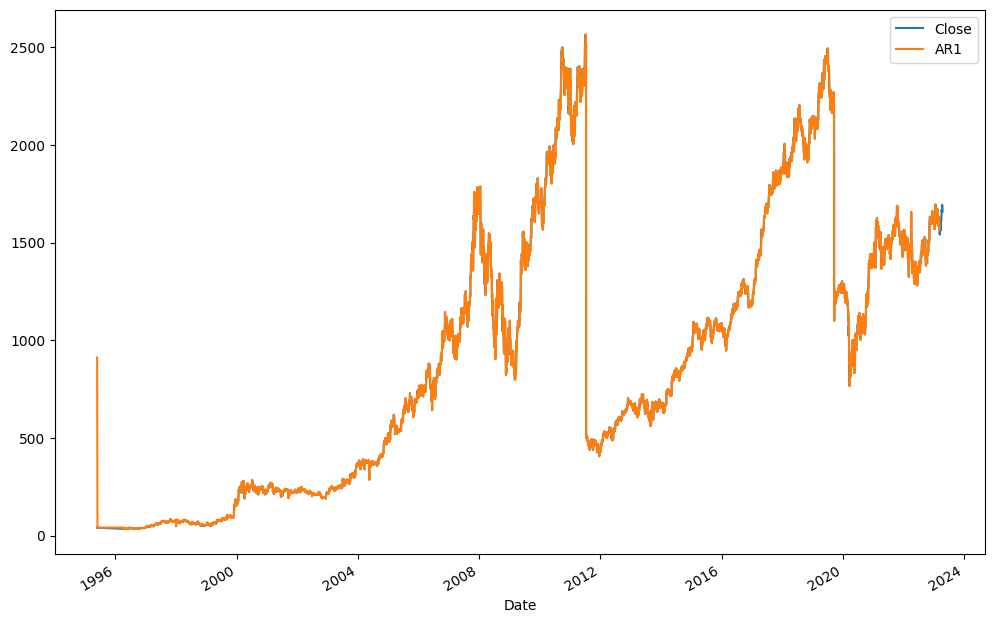

In [94]:
hdfc_stock_data.loc[train_idx,'AR1'] = res_ar1.predict(start=train.index[0],end=train.index[-1])
hdfc_stock_data[['Close','AR1']].plot(figsize=(12,8));

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


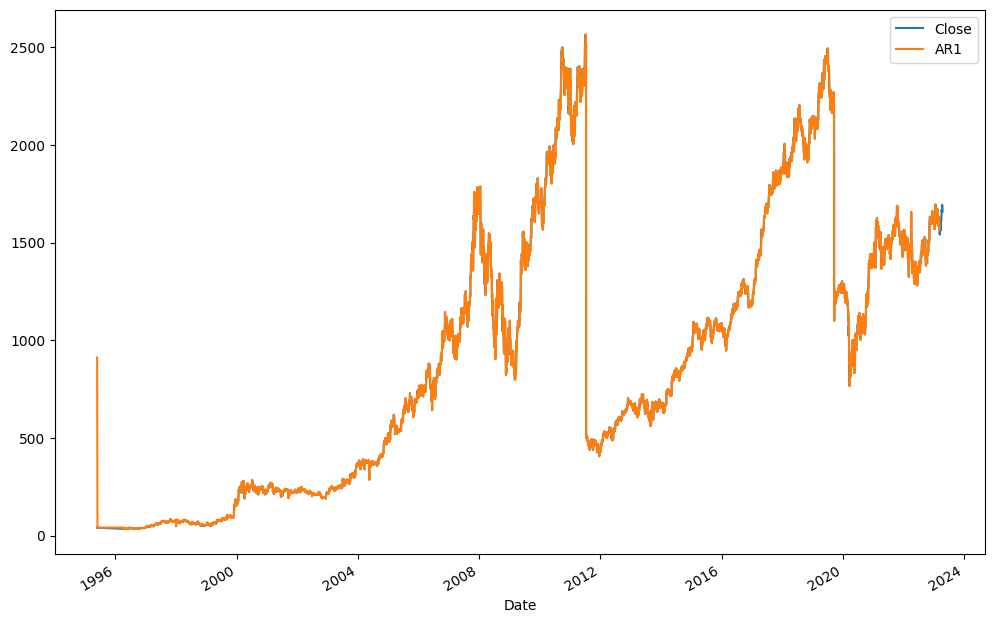

In [95]:
ar1_results = res_ar1.get_forecast(N_Test)
forecast = ar1_results.predicted_mean
hdfc_stock_data.loc[test_idx,'AR1'] = forecast
hdfc_stock_data[['Close','AR1']].plot(figsize=(12,8));

In [96]:
# Displaying the confidence intervals for the forecasted values generated by the ARIMA AR model
ar1_results.conf_int()

,lower Close,upper Close
6693,1474.155844,1605.697274
6694,1446.151232,1632.057159
6695,1424.513718,1652.052101
6696,1406.179253,1668.746145
6697,1389.960143,1683.326981
6698,1375.246840,1696.404155
6699,1361.676995,1708.340013
6700,1349.014357,1719.370805
6701,1337.094709,1729.660743
6702,1325.798406,1739.329469


In [97]:
# Custom function for visualizing the original closing stock price data of HDFC bank, train predictions and test forecasts together along with the confidence intervals as the bounding area
def plot_fit_and_forecast(result):
  fig, ax = plt.subplots(figsize=(15,8))
  ax.plot(hdfc_stock_data.Close,label='data',color='green')
  train_pred = result.predict(start=train.index[0],end=train.index[-1])
  ax.plot(train.index,train_pred,label='fitted',color='crimson')
  test_result = result.get_forecast(N_Test)
  forecast = test_result.predicted_mean
  ax.plot(test.index,forecast,label='forecast',color='cyan')
  conf_intervals = test_result.conf_int()
  lower, upper = conf_intervals['lower Close'], conf_intervals['upper Close']
  ax.fill_between(test.index,lower,upper,color='indigo',alpha=0.4)
  ax.legend();

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


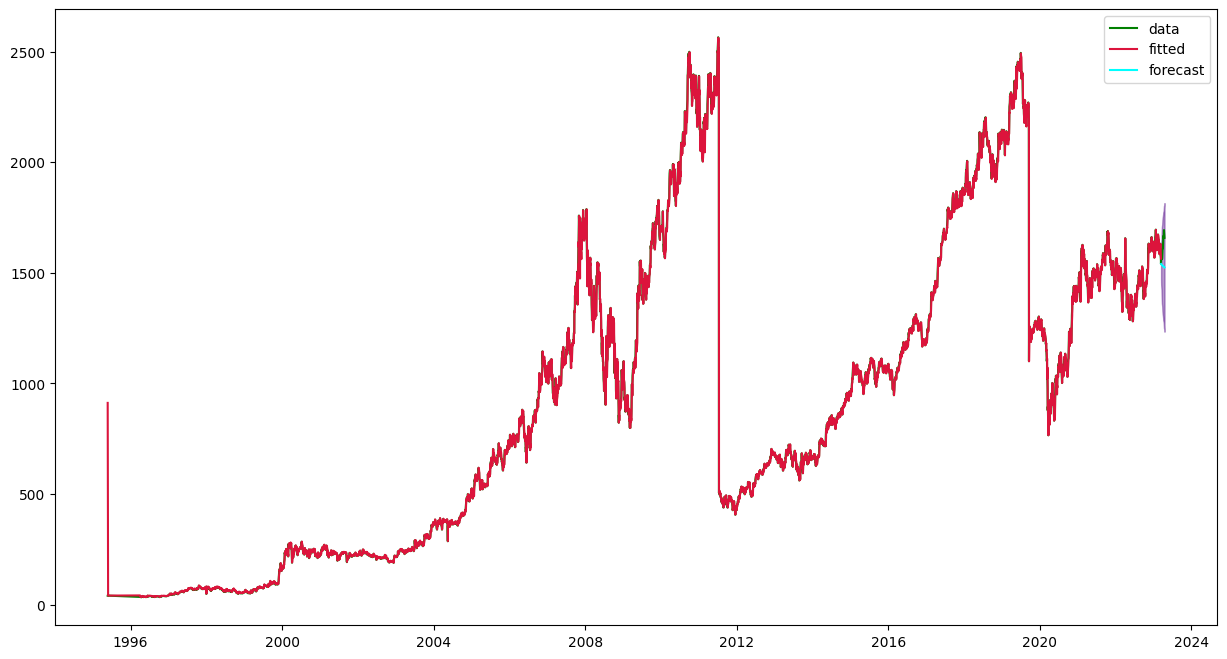

In [98]:
plot_fit_and_forecast(res_ar1)

## ARIMA (0,0,1) Moving Average (MA) Model

In [99]:
ar_001 = ARIMA(train.Close,order=(0,0,1))
res_ar_001 = ar_001.fit()

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


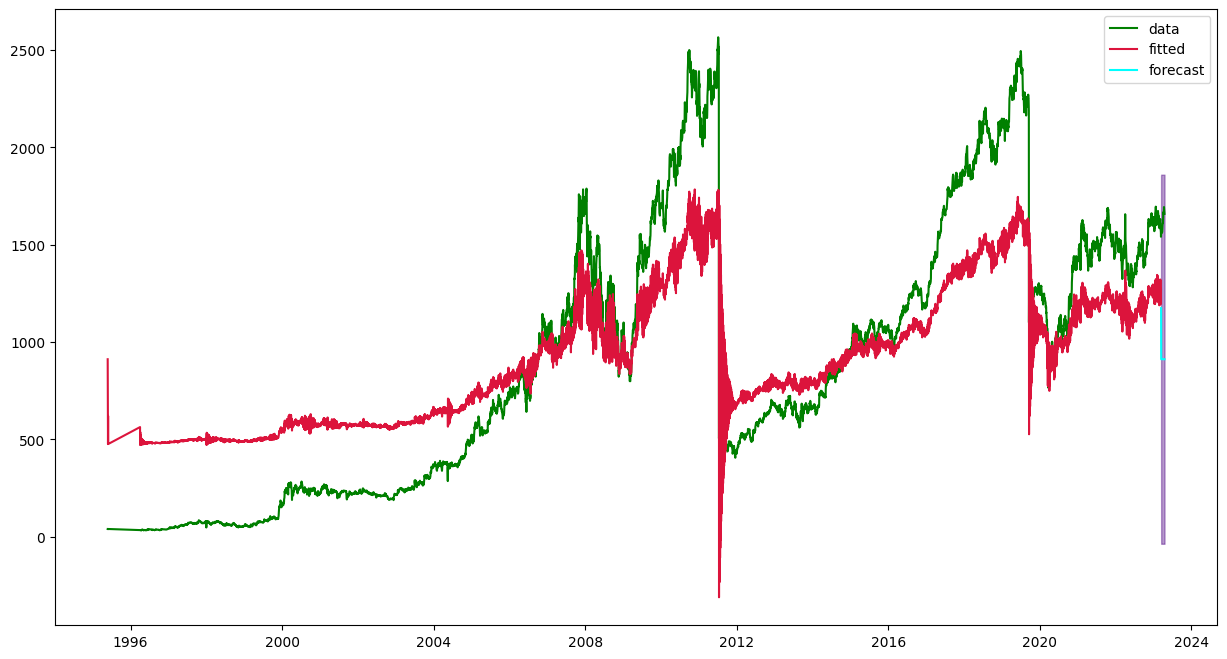

In [100]:
plot_fit_and_forecast(res_ar_001);

## ARIMA Model with order (8,1,1)

In [101]:
ar_811 = ARIMA(train.Close,order=(8,1,1))
res_ar_811 = ar_811.fit()

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


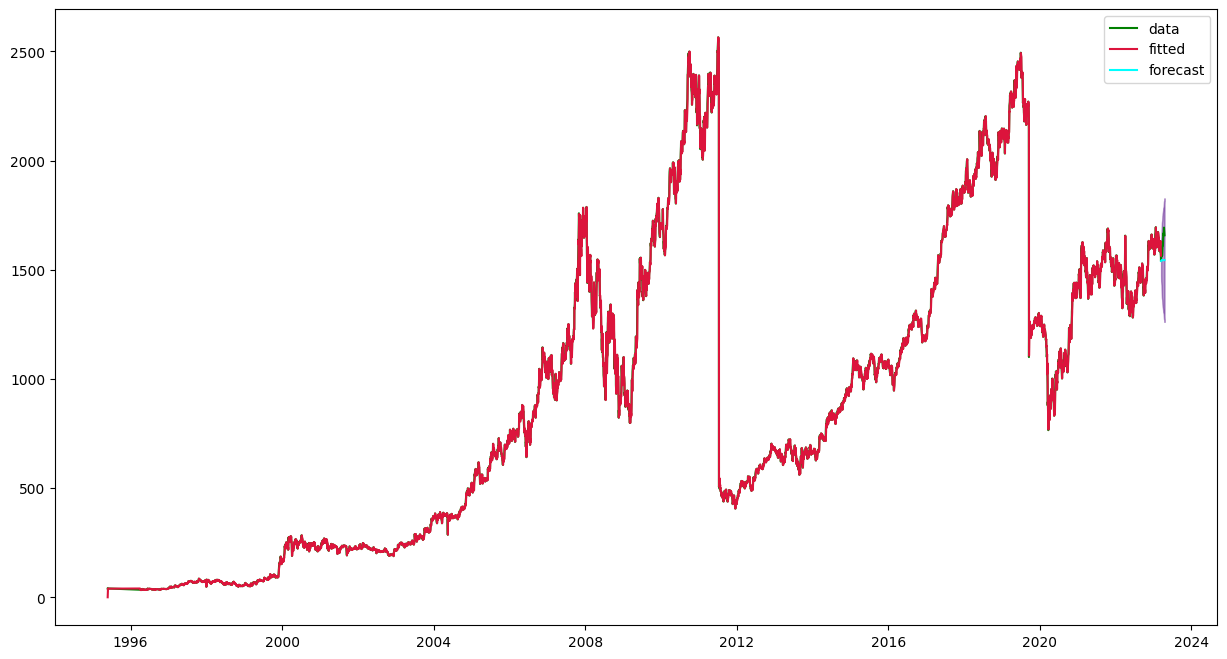

In [102]:
plot_fit_and_forecast(res_ar_811);

## ARIMA model with order (12,1,1)

In [103]:
ar_1211 = ARIMA(train.Close,order=(12,1,1))
res_ar_1211 = ar_1211.fit()

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


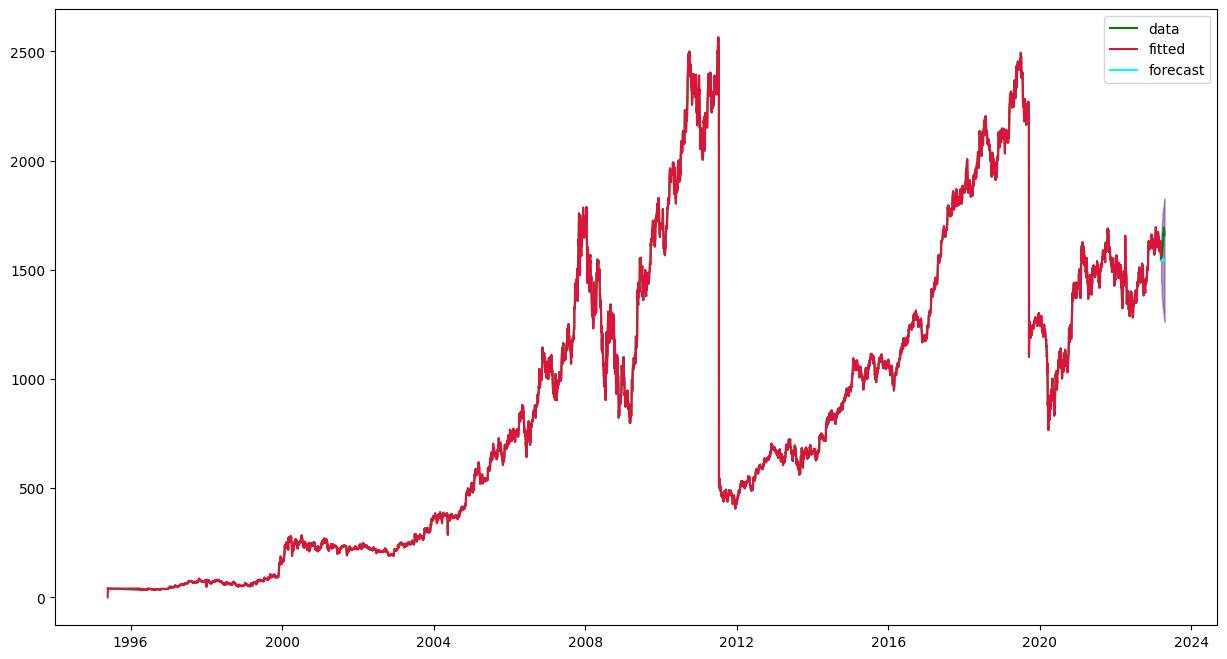

In [104]:
plot_fit_and_forecast(res_ar_1211);

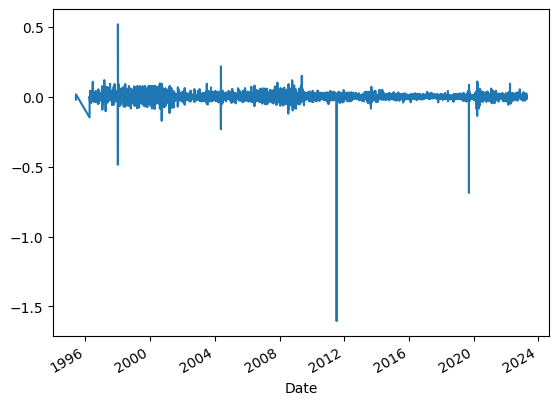

In [105]:
# Creating a new feature to compute the first difference of the log closing HDFC stock prices
hdfc_stock_data['LogClose1stDiff'] = hdfc_stock_data.LogClose.diff()
hdfc_stock_data.LogClose1stDiff.plot();

In [106]:
# Custom function for plotting train predictions, test forecasts and confidence intervals of the test predictions together with "d" being the prediction steps
def plot_fit_and_forecast_int(result,d,col='Close'):
  fig, ax = plt.subplots(figsize=(14,8))
  ax.plot(hdfc_stock_data[f'{col}'],label='data')
  train_pred = result.predict(start=train.index[d],end=train.index[-1])
  ax.plot(train.index[d:],train_pred,color='sienna',label='fitted')
  test_pred = result.get_forecast(N_Test)
  forecast = test_pred.predicted_mean
  ax.plot(test.index,forecast,color='red',label='forecast')
  conf_intvals = test_pred.conf_int()
  lower, upper = conf_intvals[f'lower {col}'], conf_intvals[f'upper {col}']
  ax.fill_between(test.index,lower,upper,color='yellow',alpha=0.3)
  ax.legend();

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


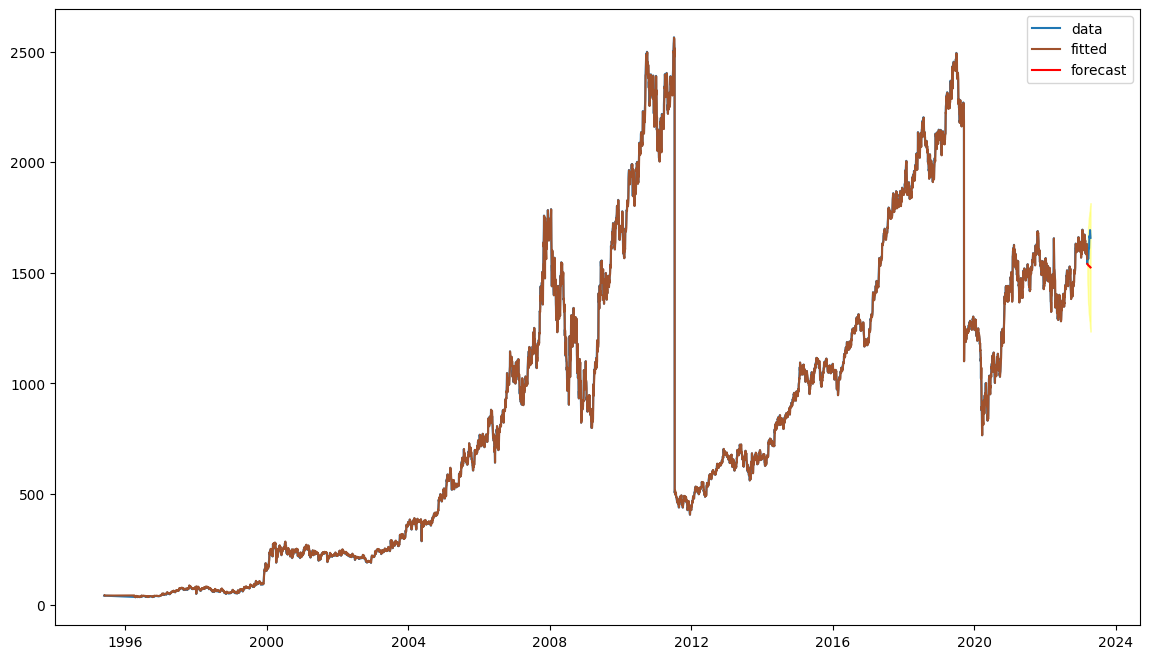

In [107]:
plot_fit_and_forecast_int(res_ar1,1); # Auto Regressive AR(1) ARIMA model

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


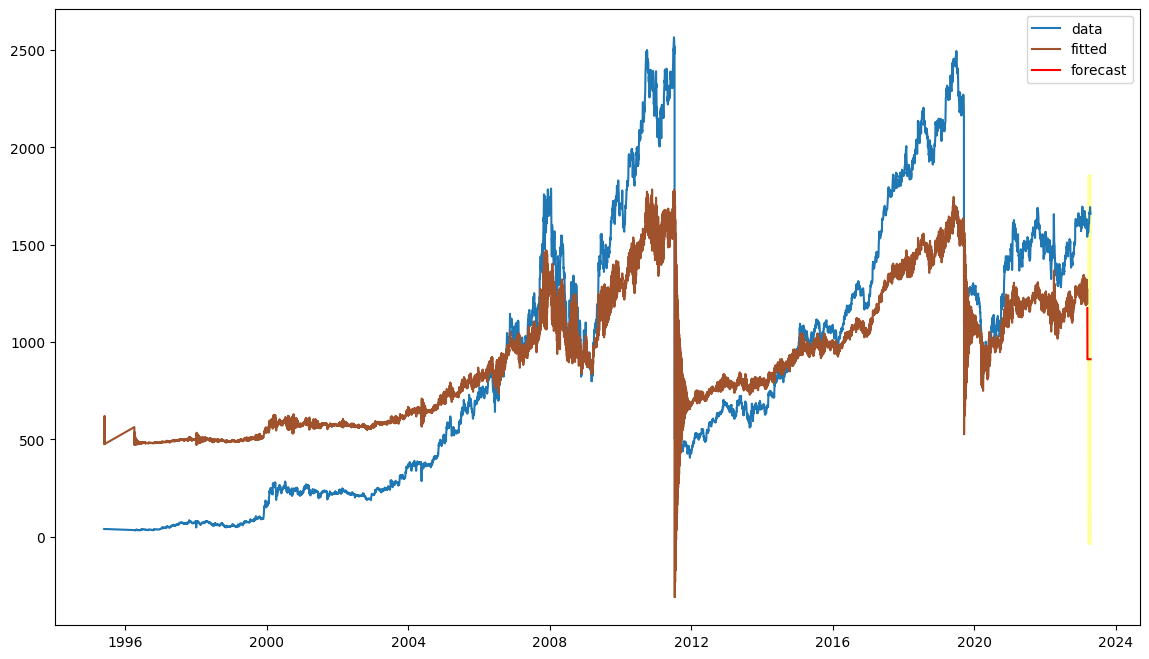

In [108]:
plot_fit_and_forecast_int(res_ar_001,1); # MA ARIMA model

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


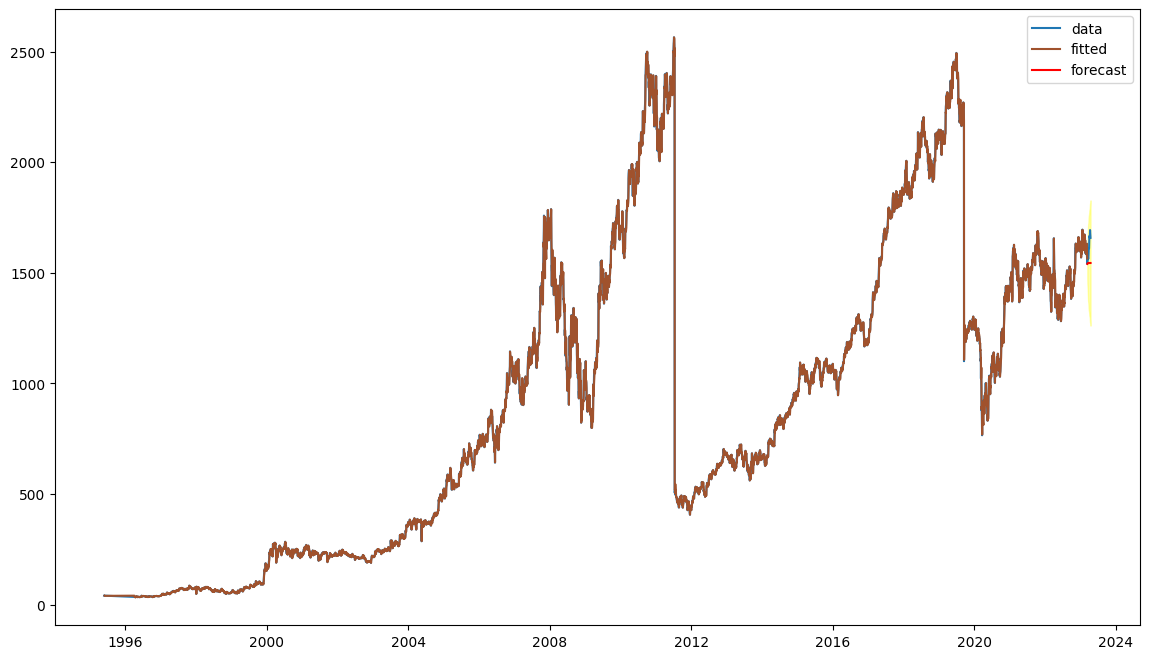

In [109]:
plot_fit_and_forecast_int(res_ar_811,1);

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


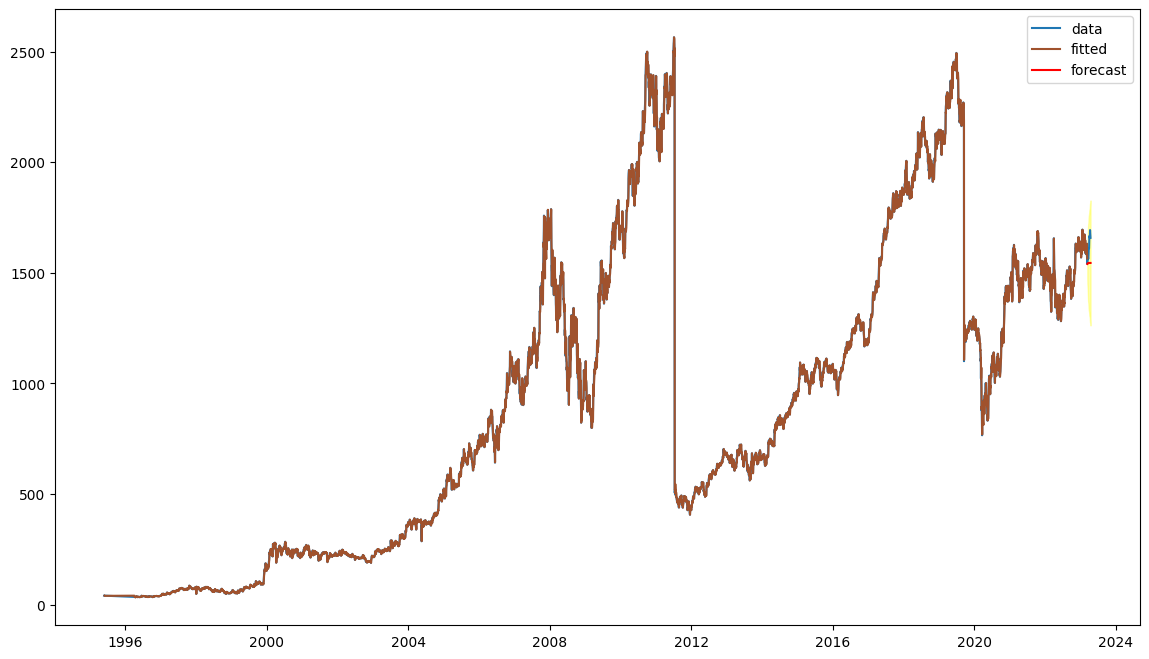

In [110]:
plot_fit_and_forecast_int(res_ar_1211,1);

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


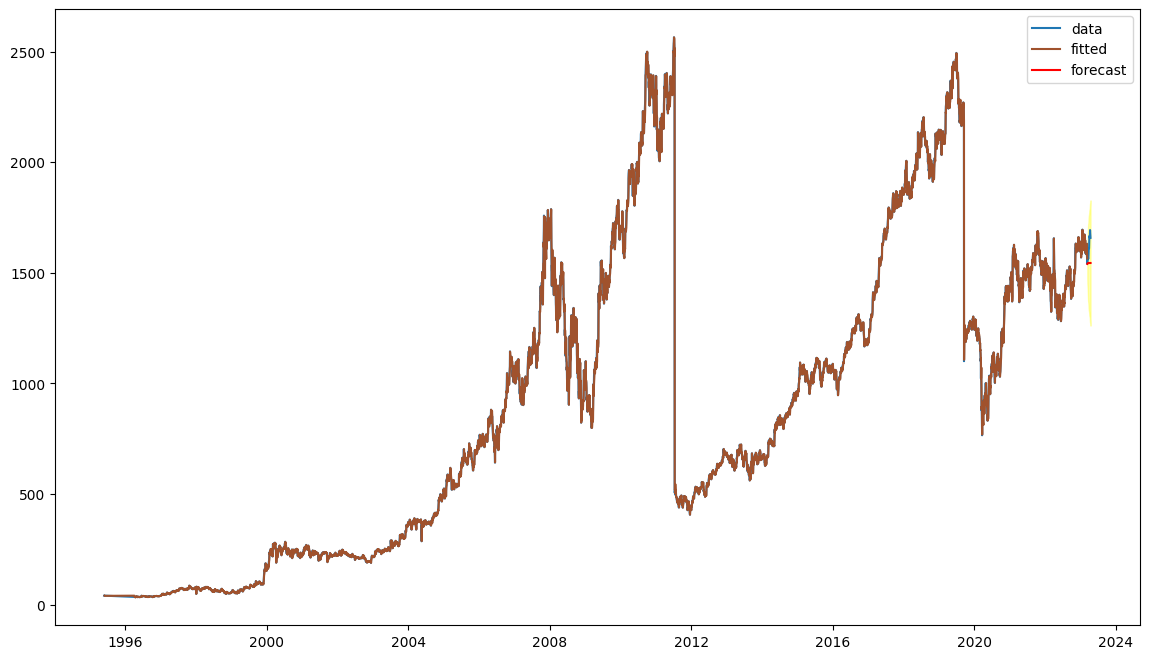

In [111]:
arima_811 = ARIMA(train['Close'],order=(8,1,1)) # ARIMA with order (8,1,1)
res_arima_811 = arima_811.fit()
plot_fit_and_forecast_int(res_arima_811,1)

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


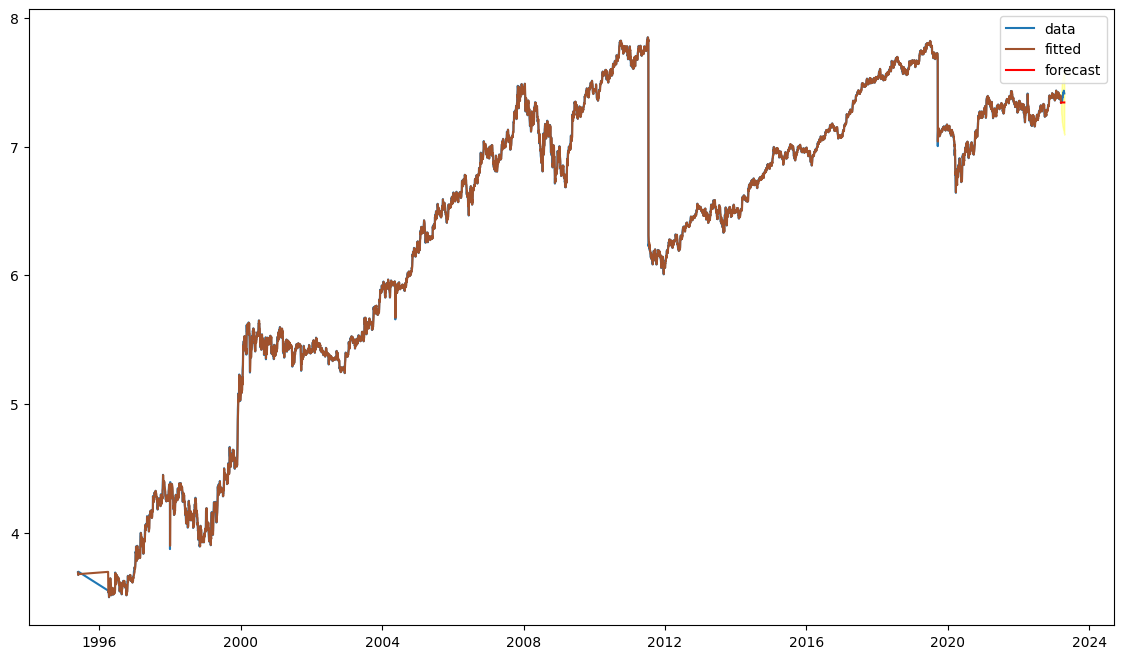

In [112]:
arima_log_811 = ARIMA(train['LogClose'],order=(8,1,1)) # ARIMA log model with order (8,1,1)
res_arima_log_811 = arima_log_811.fit()
plot_fit_and_forecast_int(res_arima_log_811,1,'LogClose')

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


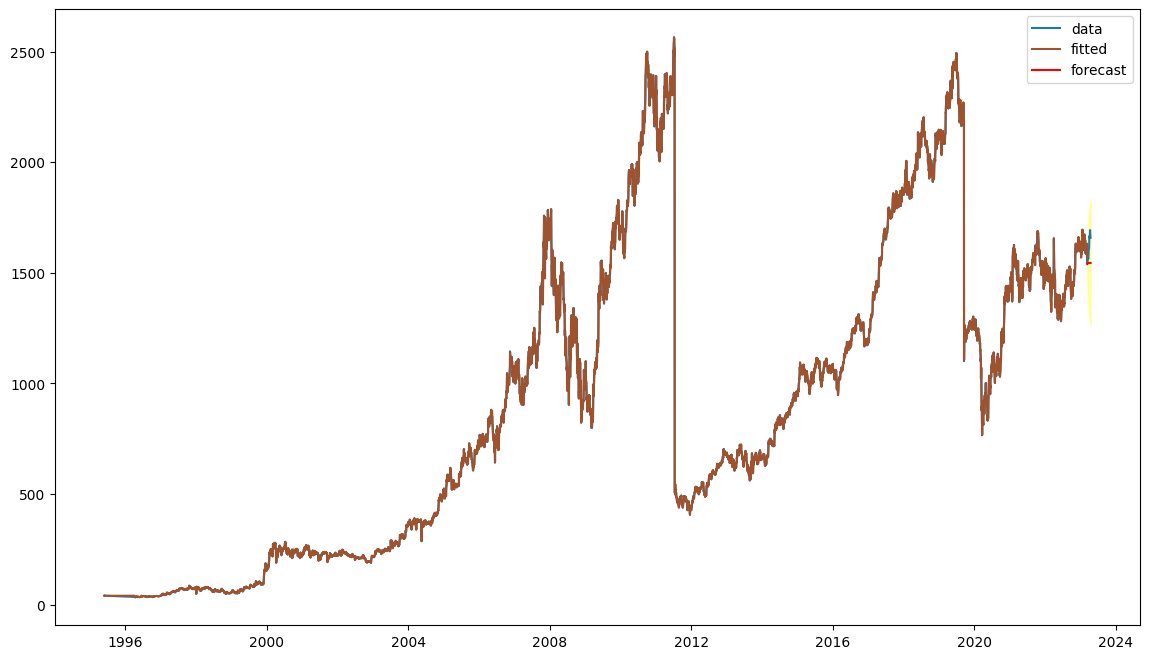

In [113]:
arima_1210 = ARIMA(train['Close'],order=(12,1,0)) # ARIMA model with order (12,1,0)
res_arima_1210 = arima_1210.fit()
plot_fit_and_forecast_int(res_arima_1210,1)

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


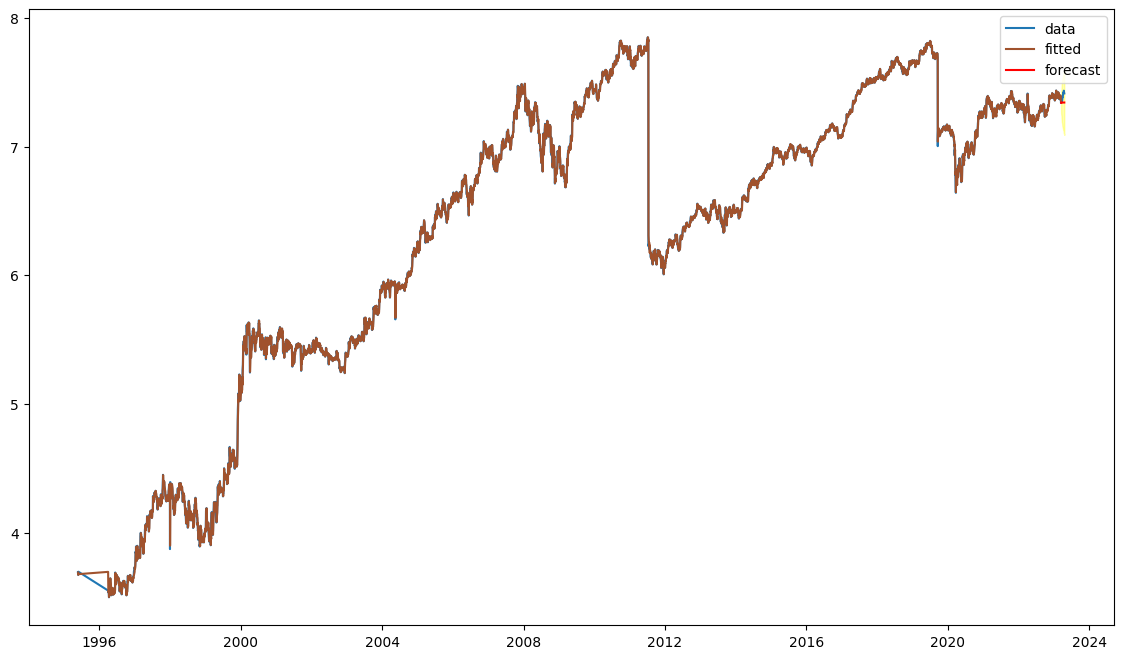

In [114]:
arima_log_1210 = ARIMA(train['LogClose'],order=(12,1,0)) # ARIMA log model with order (12,1,0)
res_arima_log_1210 = arima_log_1210.fit()
plot_fit_and_forecast_int(res_arima_log_1210,1,'LogClose')

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


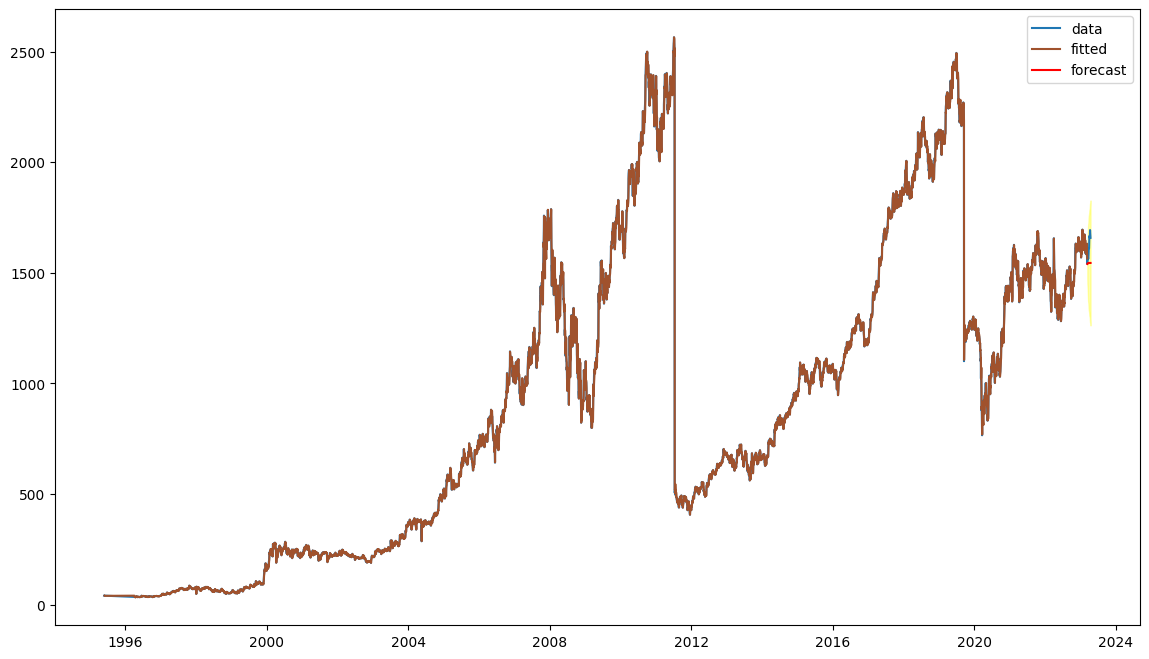

In [115]:
ar_1211 = ARIMA(train.Close,order=(12,1,1)) # ARIMA model with order (12,1,1)
res_arima_1211 = ar_1211.fit()
plot_fit_and_forecast_int(res_arima_1211,1);

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


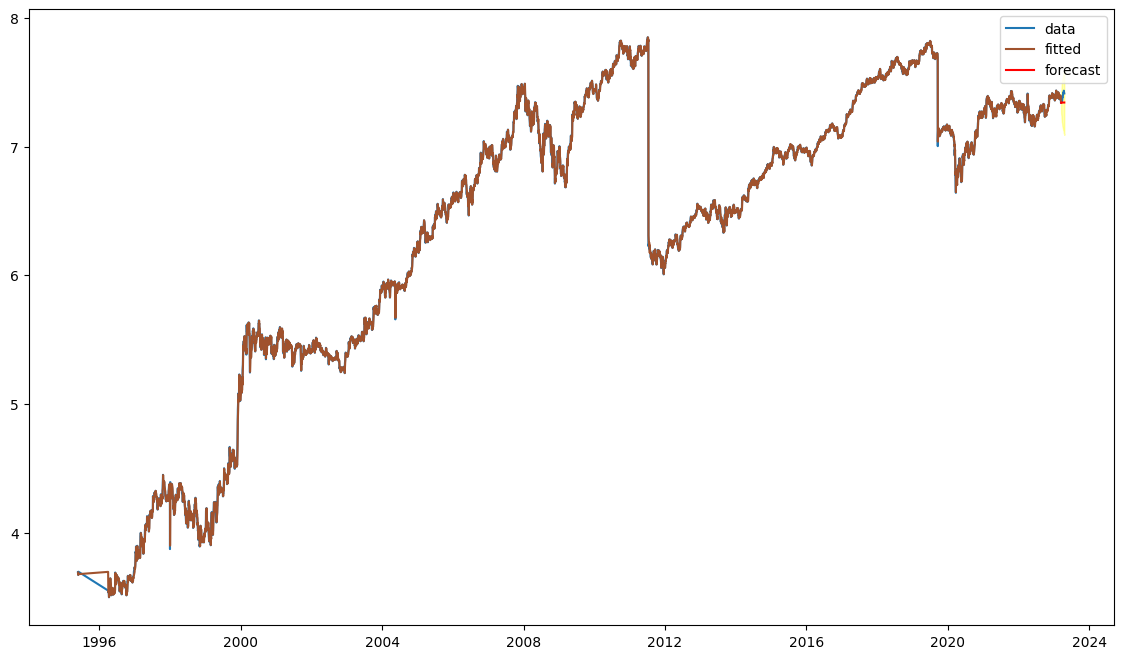

In [116]:
arima_log_1211 = ARIMA(train['LogClose'],order=(12,1,1)) # ARIMA log model with order (12,1,1)
res_arima_log_1211 = arima_log_1211.fit()
plot_fit_and_forecast_int(res_arima_log_1211,1,'LogClose')

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834:

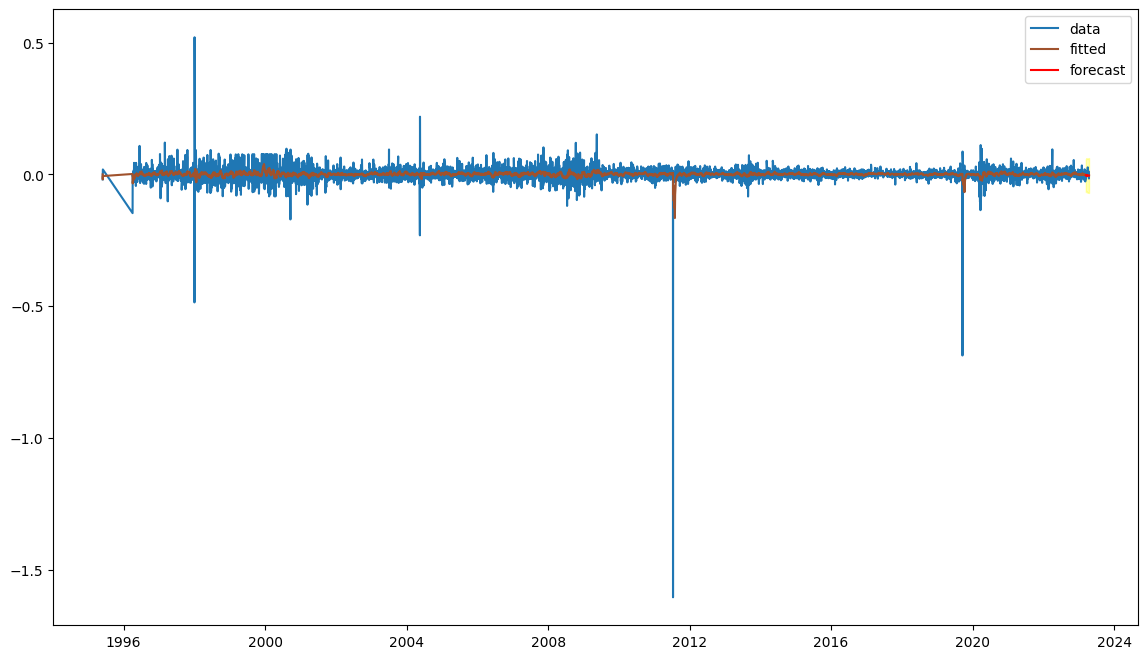

In [117]:
ar_log_diff_1211 = ARIMA(train.Diff_Log_Close.dropna(),order=(12,1,1)) # ARIMA diff log model with order (12,1,1)
res_arima_log_diff_1211 = ar_log_diff_1211.fit()
plot_fit_and_forecast_int(res_arima_log_diff_1211,1,'Diff_Log_Close');

## Evaluating the ARIMA models

In [138]:
# Custom function for computing RMSE to evaluate the forecasts generated by ARIMA models
def rmse(result,is_logged):
  forecast = result.forecast(N_Test)
  
  if is_logged: 
    forecast = np.exp(forecast) # Used to regenerate the original forecasts if LogClose and LogDiff columns are used for training the ARIMA models
  
  y = test.Close.values
  t = forecast
  return np.sqrt(np.mean((y-t)**2))

In [119]:
print("ARIMA (8,1,1):",rmse(res_arima_811,False))
print("ARIMA (8,1,1) Log:",rmse(res_arima_log_811,True))
print("ARIMA (12,1,0):",rmse(res_arima_1210,False))
print("ARIMA (12,1,0) Log:",rmse(res_arima_log_1210,True))
print("ARIMA (12,1,1):",rmse(res_arima_1211,False))
print("ARIMA (12,1,1) Log:",rmse(res_arima_log_1211,True))

ARIMA (8,1,1): 83.85571498452661
ARIMA (8,1,1) Log: 83.0208640606379
ARIMA (12,1,0): 83.73836421756407
ARIMA (12,1,0) Log: 83.55030664208897
ARIMA (12,1,1): 83.72656360403663
ARIMA (12,1,1) Log: 83.50382999527551


D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is

In [135]:
# Custom function for computing RMSE to evaluate the performance of ARIMA log difference models
def rmse_diff_log_close(result,is_logged):
  forecast = result.forecast(N_Test)
  
  if is_logged:
    forecast = np.exp(forecast)  
  
  y = test.Diff_Log_Close.values
  t = forecast
  return np.sqrt(np.mean((y-t)**2))

In [136]:
print("ARIMA (12,1,1) Log Difference:")
print("RMSE:",rmse(res_arima_log_diff_1211,True))

ARIMA (12,1,1) Log Difference:
RMSE: 0.9924312403335397


D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


## SARIMA Model with order (12,1,1)

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


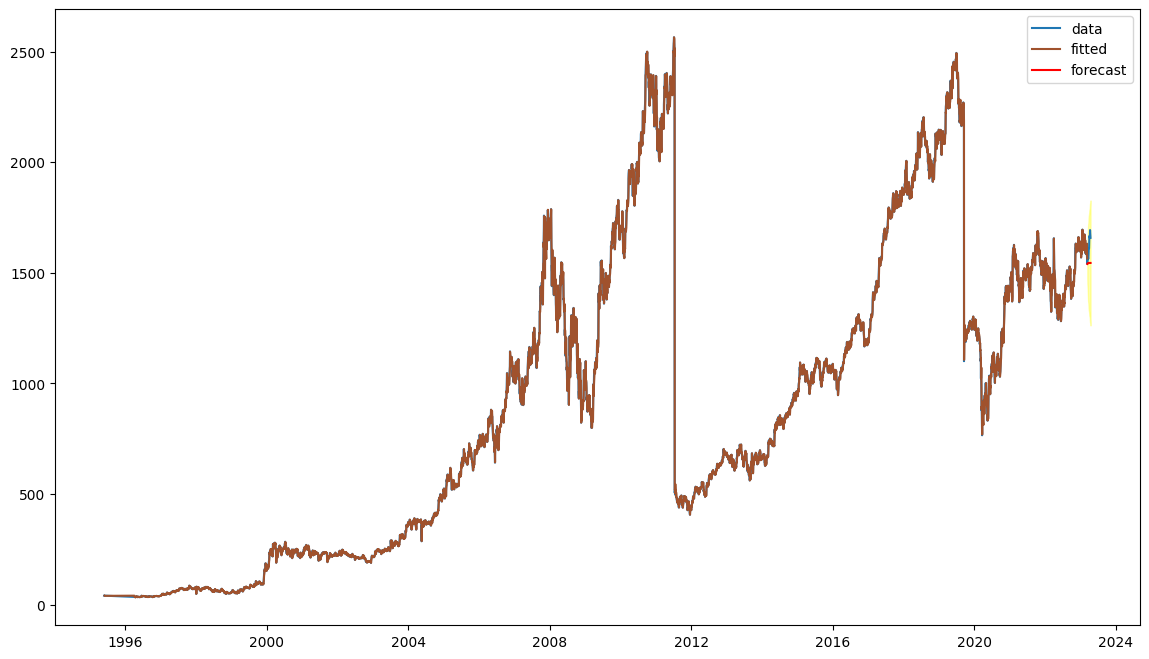

In [137]:
sarima_model = SARIMAX(endog=train.Close,order=(12,1,1))
res_sarima = sarima_model.fit()
plot_fit_and_forecast_int(res_sarima,1);

In [140]:
print("SARIMA (12,1,1) RMSE:",rmse(res_sarima,False))

SARIMA (12,1,1) RMSE: 83.72656360403663


D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


## SARIMA log model with order (24,1,1)

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


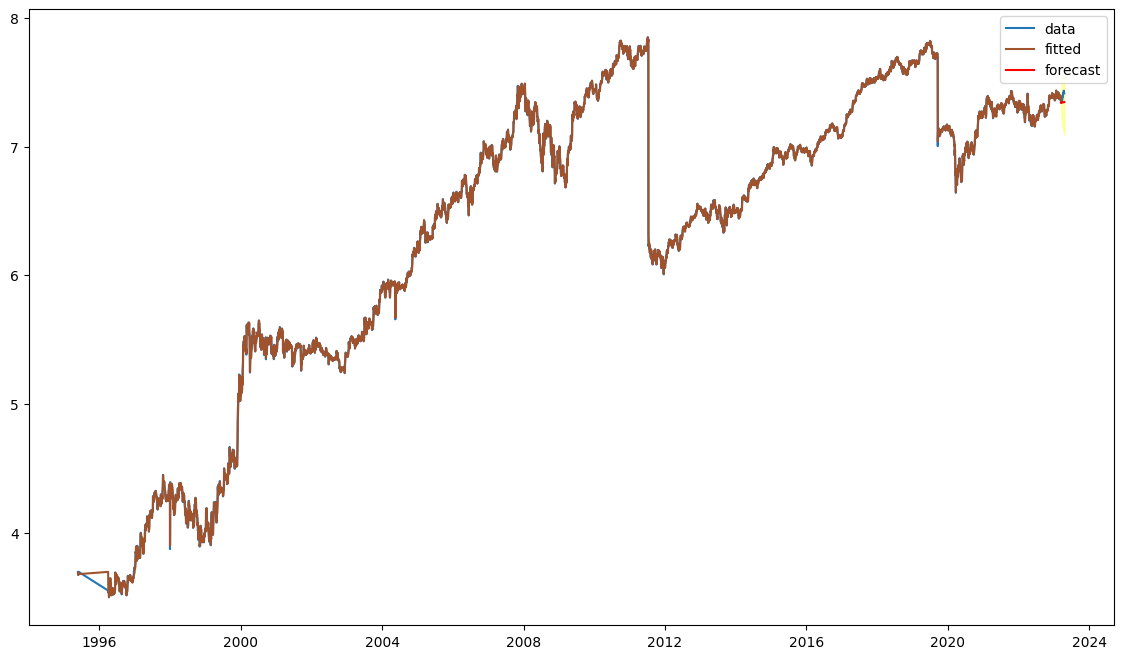

In [153]:
sarima_log_model = SARIMAX(endog=train.LogClose,order=(24,1,1))
res_sarima = sarima_log_model.fit()
plot_fit_and_forecast_int(res_sarima,1,'LogClose');

In [154]:
print("SARIMAX (24,1,1) Log Close RMSE:",rmse(res_sarima,True))

SARIMAX (24,1,1) Log Close RMSE: 81.16358553131572


D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


## SARIMA Diff Log Model with order (24,1,1)

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


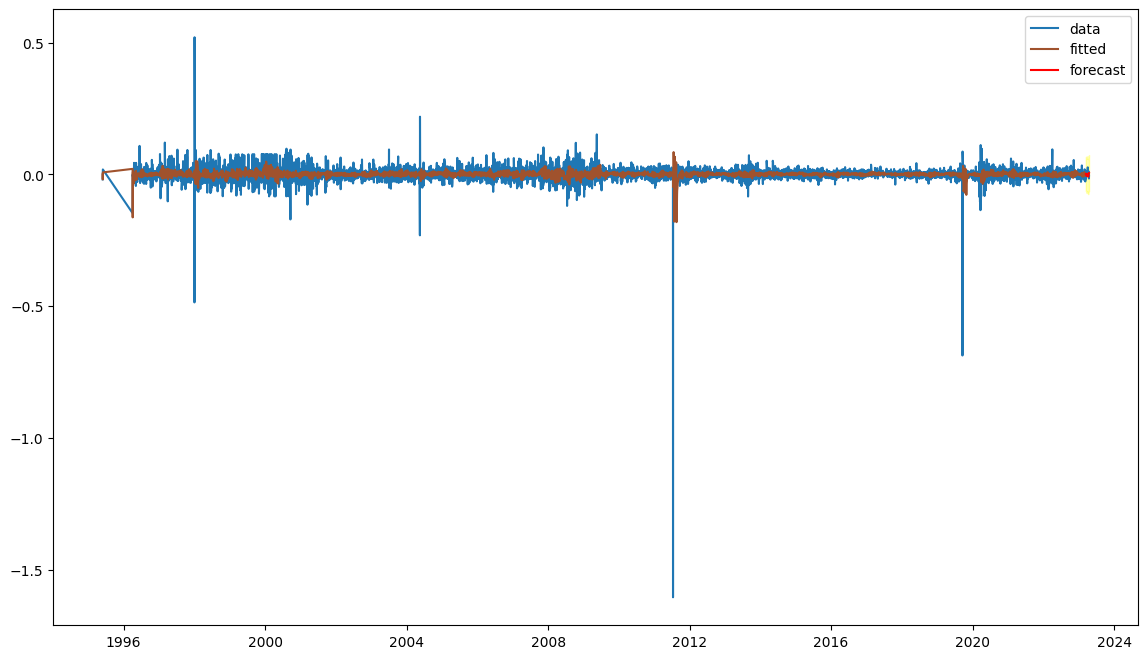

In [159]:
sarima_diff_log_model = SARIMAX(endog=train.Diff_Log_Close.dropna(),order=(24,1,1))
res_sarima = sarima_diff_log_model.fit()
plot_fit_and_forecast_int(res_sarima,1,'Diff_Log_Close');

In [160]:
print("SARIMA (12,1,1) Log Difference RMSE:",rmse_diff_log_close(res_sarima,True))

SARIMA (12,1,1) Log Difference RMSE: 0.9948849809020305


D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


The SARIMA (12,1,1) Log Model achieves the best performance by obtaining the least RMSE score of about 81.16 as compared to all other ARIMA and SARIMA models used.